## Analyses and figures presented in the manuscript _Accurate model of liquid-liquid phase behavior of intrinsically-disordered proteins from data-driven optimization of single-chain properties_ by G. Tesei, T. Klarsø Schulze, R. Crehuet, and K. Lindorff-Larsen

Authors: Giulio Tesei and Thea Klarsø Schulze

Contact: giulio.tesei@bio.ku.dk

The cells below reproduce the data analyses presented in the manuscript _Accurate model of liquid-liquid phase behavior of intrinsically-disordered proteins from data-driven optimization of single-chain properties_, expept for the calculation of $c_{sat}$ and $K_d$, which are detailed in the notebooks `calcConc.ipynb` and `calcKd.ipynb`, respectively. Fig. S14–S16 the data in `multi-chain/data/M1`, `multi-chain/data/M2`, `multi-chain/data/M3`, `multi-chain/data/HPS` and `multi-chain/data/Urry` which are available on Zenodo at DOI.

List of main-text figures:
* [Fig. 1](#1)
* [Fig. 3](#3)
* [Fig. 4](#4)
* [Fig. 5](#5)
* [Fig. 6](#6)
* [Fig. 7](#7)
* [Fig. 8](#8)

List of SI figures:
* [Fig. S1](#S1)
* [Fig. S2](#S2)
* [Fig. S3](#S3)
* [Fig. S4](#S4)
* [Fig. S5–S10](#S5–S10)
* [Fig. S11](#S11)
* [Fig. S12](#S12)
* [Fig. S13](#S13)
* [Fig. S14](#S14)
* [Fig. S15](#S15)
* [Fig. S16](#S16)
* [Fig. S17](#S17)
* [Fig. S18](#S18)
* [Fig. S19](#S19)
* [Fig. S20](#S20)

In [1]:
import numpy as np
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit, least_squares
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from itertools import combinations
from sklearn.covariance import LedoitWolf, ShrunkCovariance
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
from cycler import cycler
cm = ['#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00','#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

#### Helper Functions

In [2]:
def plotErr(ax,p,color,width,names,label):
    ax.bar(p.index,(p.Rg-p.expRg)/p.expRg*100,width=width,color=cm[color],label=label)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names,rotation=90)
    
def plotPREdata_1(ax,name,label,model,c,ff):
    calcPREs = model.loc[name,'initPREs'][label]
    expPREsV = model.loc[name,'expPREs'].value[label]
    expPREsE = model.loc[name,'expPREs'].error[label]
    if ff=='HPS' or ff=='M1': 
        ax.errorbar(expPREsV.index,expPREsV.values,expPREsE.values, color='k', lw=0, 
            marker='o', ms=1, elinewidth=.5, capsize=1, capthick=.5, label='Exp')    
    ax.plot(calcPREs.index, calcPREs.values, color=cm[c], lw=.5, marker='o', ms=1,label=ff)
    ax.set_xticks(expPREsV.index[9::20])
    
def plotPREdata_2(name,proteins,c):
    initPREs = proteins.loc[name].initPREs
    expPREs = proteins.loc[name].expPREs
    labels = proteins.loc[name].labels
    obs = 1 if proteins.loc[name].obs=='ratio' else 2
    cols = 1 if len(labels)<6 else 2
    rows = int(len(labels) / cols)
    if obs == 1:
        ylabel = '$I_{para}$  /  $I_{dia}$' 
    else:
        ylabel = '$\Gamma_2$  /  Hz' 
   
    for ax,label in zip(axes.flatten(),labels):
        ax.errorbar(expPREs.index,expPREs.value[label],expPREs.error[label], color='k', lw=0, 
            marker='o', ms=1, elinewidth=.5, capsize=1, capthick=.5)    
        ax.plot(initPREs[label].index,initPREs[label].values,color=cm[c],
                lw=0.5,marker='o',ms=1)
        if obs == 2:
            ax.set_yscale('log')
        ax.set_xticks(initPREs.index[9::10])
        if len(proteins.loc[name].fasta)>200:
            ax.set_xticks(initPREs.index[9::30])
        if len(proteins.loc[name].fasta)>400:
            ax.set_xticks(initPREs.index[9::60])
        ax.set_ylabel(ylabel)
    if cols == 2:
        axes.flatten()[-2].set_xlabel('Residue #')
        for i in np.arange(len(labels))[1::2]:
            axes.flatten()[i].yaxis.set_label_position("right")
            axes.flatten()[i].yaxis.set_ticks_position('right')

    axes.flatten()[-1].set_xlabel('Residue #')
    plt.tight_layout(w_pad=0.5)
        
def plotInterPREdata(ax,ff,label,protein,c):
    calcPREsV = protein.loc['calcPREs',ff].value[label]
    calcPREsE = protein.loc['calcPREs',ff].error[label]
    expPREsV = protein.loc['expPREs',ff].value[label]
    expPREsE = protein.loc['expPREs',ff].error[label]

    ax.errorbar(expPREsV.index,expPREsV.values,expPREsE.values, color='k', lw=0, 
        marker='o', ms=1, elinewidth=.5, capsize=1, capthick=.5)    
    ax.plot(calcPREsV.index, calcPREsV.values, color=cm[c], lw=0.5,marker='o',ms=1)
    ax.set_xticks(expPREsV.index[9::10])
    
def plotMap(ax,df,label,vmin,vmax,cmap=plt.cm.bwr,xlabel='Single Chain',ylabel='Single Chain',ori='vertical',
            cbar=True):
    df = df*1e3
    im = ax.imshow(df,extent=[1, df.shape[0], 1, df.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,aspect='equal',
                 vmin=vmin,vmax=vmax)
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="5%", pad=.1)
        else:
            cax = divider.new_vertical(size="5%", pad=.15)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=r'{:s}'.format(label))
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plotCvsTime(ax,name,model,label,temp=323,nskip=1200):
    df_proteins = pd.read_pickle('multi-chain/proteins.pkl')
    hpro = np.load('multi-chain/data/{:s}/{:s}_{:d}.npy'.format(model,name,temp))
    hpro = hpro[nskip:]/len(df_proteins.loc[name].fasta)/15/15/0.1/6.022*10*1e3
    print(hpro.max())
    Lz = (hpro.shape[1]+1)/20
    im = ax.imshow(hpro,extent=[-Lz, Lz,0, hpro.shape[0]*250/1e6], 
                 interpolation='bicubic', cmap=plt.cm.Blues,vmin=1e-2,vmax=1e2,
                 origin='lower',alpha=1,aspect='auto',norm=LogNorm())
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.15)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation="horizontal", label=r'{:s}'.format(label))
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    ax.set_xlim(-Lz,Lz)
    ax.set_xlabel('$z$  /  nm')
    return hpro

def plotCprofile(ax,h):
    lz = (h.shape[1]+1)
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[hm.min(),hm.max(),3,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[1e3]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[1e3]*4))
    ax.plot(z1,h1,color=cm[1],lw=1)
    ax.plot(z2,h2,color=cm[1],lw=1,alpha=.6)
    ax.plot(z,profile(z,*res1.x),color=cm[1],lw=.5)
    ax.plot(z,profile(z,*res2.x),color=cm[1],lw=.5,alpha=.6)
    ax.set_yscale('log')
    ax.set_xlabel('$z$  /  nm')
    ax.set_xlim(-lz/20,lz/20)
    ax.set_ylim(1e-2,1e2)
    if (res1.x[3]>res1.x[2]) or (res2.x[3]>res2.x[2]):
        zDS = res1.x[2] if res1.x[2]>res2.x[2] else res2.x[2]
        zDS = 10 if zDS<1 else zDS
        cutoffs1 = [zDS,-zDS]
        cutoffs2 = [zDS+25,-zDS-25]
    else:
        cutoffs1 = [res1.x[2]-.5*res1.x[3],-res2.x[2]+.5*res2.x[3]]
        cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]
    ax.vlines(cutoffs2,1e-2,1e2,color=cm[0],ls=':')
    ax.vlines(cutoffs1,1e-2,1e2,color='k',ls=':')

<a id='1'></a>

### Fig. 1

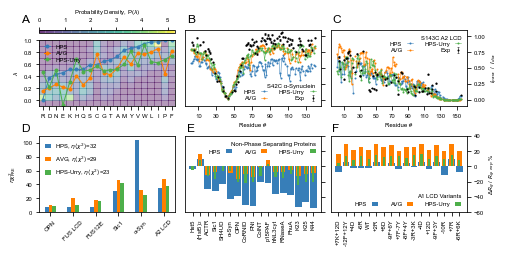

In [3]:
fig, [(ax1,ax2,ax3),(ax4,ax5,ax6)] = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(7,3.5))

dfpriorO = pd.read_pickle('optimization/prior.pkl')
cols = np.arange(-.1,1.05,.1)
dfprior = pd.DataFrame(index=dfpriorO.index,columns=pd.cut(cols[1:],cols),
                    data=np.zeros((dfpriorO.index.size,np.arange(-0.05,1.05,.1).size)))
dfprior.iloc[:,1:] = dfpriorO
dfparams = pd.read_csv('residues.csv').set_index('three')
im = ax1.pcolor(dfprior.T,alpha=.4)
ax1.set_xticks(np.arange(.5,20,1))
ax1.set_xticklabels(dfprior.index)
ax1.plot(np.arange(.5,20,1),dfparams.HPS*10+1,marker='o',ms=3,lw=1,
         color=cm[0],label='HPS')
ax1.plot(np.arange(.5,20,1),dfparams.AVG*10+1,marker='o',ms=3,lw=1,
         color=cm[1],label='AVG')
ax1.plot(np.arange(.5,20,1),dfparams.Urry*10+1,marker='o',ms=3,lw=1,color=cm[2],label='HPS-Urry')
ax1.set_ylabel('$\lambda$')
ax1.set_yticks(np.arange(.1,1.2,.2)*10)
ax1.set_yticklabels(['{:.1f}'.format(i) for i in np.arange(0,1.1,.2)])
ax1.legend(frameon=False,loc=(.02,.63),labelspacing=.2,handlelength=1)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1)
fig.add_axes(cax)
plt.colorbar(im, cax=cax, orientation="horizontal", label=r'Probability Density, P($\lambda$)')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

HPS = pd.read_pickle('optimization/10_HPS/o1_init_proteins.pkl')
AVG = pd.read_pickle('optimization/10_AVG/o1_init_proteins.pkl')
l5 = pd.read_pickle('optimization/Urry/o1_init_proteins.pkl')
df_pre = pd.DataFrame({r'HPS, $\eta\langle \chi^2 \rangle$={:.0f}'.format(HPS.chi2_pre.mean()):HPS.chi2_pre,
                      r'AVG, $\eta\langle \chi^2 \rangle$={:.0f}'.format(AVG.chi2_pre.mean()):AVG.chi2_pre,
                      r'HPS-Urry, $\eta\langle \chi^2 \rangle$={:.0f}'.format(l5.chi2_pre.mean()):l5.chi2_pre})
df_pre.plot.bar(ax=ax4)
ax4.set_ylim(0,110)

plotPREdata_1(ax2,'aSyn',42,HPS,0,'HPS')
plotPREdata_1(ax2,'aSyn',42,AVG,1,'AVG')
plotPREdata_1(ax2,'aSyn',42,l5,2,'HPS-Urry')

plotPREdata_1(ax3,'A2',143,HPS,0,'HPS')
plotPREdata_1(ax3,'A2',143,AVG,1,'AVG')
plotPREdata_1(ax3,'A2',143,l5,2,'HPS-Urry')

leg = ax2.legend(title=r'S42C α-Synuclein',frameon=False,handlelength=1,
                 markerfirst=False,ncol=2,labelspacing=.2)
leg._legend_box.align = "right"
leg = ax3.legend(title='S143C A2 LCD',frameon=False,handlelength=1,
                markerfirst=False,ncol=2,labelspacing=.2)
leg._legend_box.align = "right"
ax2.set_ylim(-.1,1.1)
ax3.set_ylim(-.1,1.1)
ax2.set_xlabel('Residue #')
ax3.set_xlabel('Residue #')
ax3.set_ylabel('$I_{para}$  /  $I_{dia}$')

solub = ['Hst5','Hst52','ACTR','Sic92','SH4UD','aSyn140','OPN220','CoRNID','PNt','ColNT','p15PAF','hNL3cyt',
'RNaseA','FhuA','K23','K25','K44']
varia = ['P7KP12D','M12FP12Y','P4D','M6R','A1','P2R','P8D','M9FP6Y','P7FM7Y','M8FP4Y',
'M3RP3K','M4D','P12D','M9FP3Y','M10R','P7R','M6RP6K']

names = ['Hst5',r'(Hst5)$_2$','ACTR','Sic1','SH4UD','α-Syn','OPN','CoRNID','PNt','ColNT','p15PAF','hNL3cyt',
'RNaseA','FhuA','K23','K25','K44']
p = pd.read_pickle('optimization/10_HPS/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,0,.9,names,'HPS')
p = pd.read_pickle('optimization/10_AVG/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,1,.6,names,'AVG')
p = pd.read_pickle('optimization/Urry/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,2,.3,names,'HPS-Urry')

names = [a.replace('A1','WT').replace('M','-').replace('P','+') for a in varia]
p = pd.read_pickle('optimization/10_HPS/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,0,.9,names,'HPS')
p = pd.read_pickle('optimization/10_AVG/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,1,.6,names,'AVG')
p = pd.read_pickle('optimization/Urry/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,2,.3,names,'HPS-Urry')

leg = ax5.legend(title=r'Non-Phase Separating Proteins',frameon=False,handlelength=1,
                 markerfirst=False,ncol=3)
leg._legend_box.align = "right"
leg = ax6.legend(title=r'A1 LCD Variants',frameon=False,handlelength=1,
                 markerfirst=False,ncol=3,loc='lower right')
leg._legend_box.align = "right"

ax6.set_ylabel(r'$\Delta R_g$ / $R_{g,exp}$ %')
ax2.set_yticklabels([])
ax5.set_yticklabels([])
ax5.yaxis.set_label_position("right"); ax5.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position("right"); ax6.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position("right"); ax2.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position("right"); ax3.yaxis.set_ticks_position('right')

ax4.legend(frameon=False,ncol=1,borderaxespad=.5,handlelength=1,loc='upper left')
pre_names = ['OPN', 'FUS LCD', 'FUS12E', 'Sic1', 'α-Syn', 'A2 LCD']

ax4.set_xticklabels(pre_names,rotation=45)
ax4.set_ylabel('$\eta \chi^2_{\mathrm{PRE}}$')

ax5.set_ylim(-60,40)
ax6.set_ylim(-60,40)
ax5.set_xlim(-1,17)
ax6.set_xlim(-1,17)

fig.text(0.04, .91, 'A', fontsize=12)
fig.text(0.37, .91, 'B', fontsize=12)
fig.text(0.658, .91, 'C', fontsize=12)
fig.text(0.04, .48, 'D', fontsize=12)
fig.text(0.37, .48, 'E', fontsize=12)
fig.text(0.658, .48, 'F', fontsize=12)

plt.tight_layout()
plt.savefig('figures/Fig1.pdf')
plt.show()

Select $\lambda$ sets with largest Spearman's correlation coefficient between simulated and experimental Rg values for the A1 LCD variants.

In [4]:
opt_results = pd.DataFrame(index=['chi2_pre','chi2_rg','rs','lambdas','chi2_rgA1'],
                           columns=['M{:d}'.format(i) for i in [1,2,3]])

r = pd.read_pickle('optimization/10_5/o5_residues.pkl')
df1_0 = pd.read_pickle('optimization/10_5/o4_lambdas.pkl')
df1_1 = pd.read_pickle('optimization/10_5/o5_lambdas.pkl')
df1_2 = pd.read_pickle('optimization/10_AVG/o5_lambdas.pkl')
df1 = pd.concat((df1_0,df1_1,df1_2)).reset_index().drop('index',axis=1)
print(df1.shape)
df2_0 = pd.read_pickle('optimization/5_M1/o1_lambdas.pkl')
df2_1 = pd.read_pickle('optimization/5_M1/o2_lambdas.pkl')
df2 = pd.concat((df2_0,df2_1)).reset_index().drop('index',axis=1)
print(df2.shape)
df3 = pd.read_pickle('optimization/2_M2/o1_lambdas.pkl')
print(df3.shape)

for k,df in zip([1,2,3],[df1,df2,df3]):
    m1 = df['chi2_rg'].apply(lambda x : x.mean())
    m2 = df['chi2_pre'].apply(lambda x : x.mean())
    ndx_maxrs = df[['spearman']].idxmax()[0]
    
    opt_results.loc['lambdas','M{:d}'.format(k)] = df.loc[ndx_maxrs].lambdas.values
    opt_results.loc['ndx','M{:d}'.format(k)] = ndx_maxrs
    opt_results.loc['chi2_pre','M{:d}'.format(k)] = m2.loc[ndx_maxrs]
    opt_results.loc['chi2_rg','M{:d}'.format(k)] = m1.loc[ndx_maxrs]
    opt_results.loc['rs','M{:d}'.format(k)] = df.loc[ndx_maxrs,'spearman']

(86, 4)
(43, 4)
(58, 4)


<a id='3'></a>

### Fig. 3

0.037143979268685685 -0.02080672460101279
0.03644474353372109 -0.020314498516330215


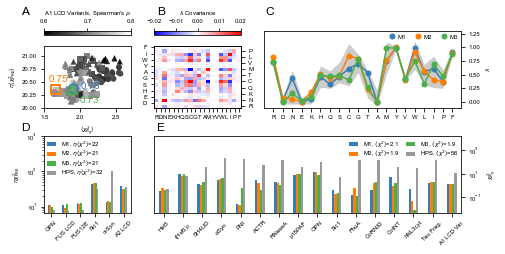

In [5]:
pre_names = ['OPN', 'FUS LCD', 'FUS12E', 'Sic1', 'α-Syn', 'A2 LCD']
p_index = ['Hst5', 'Hst52', 'SH4UD', 'aSyn140', 'PNt', 'ACTR', 'RNaseA',
       'p15PAF', 'OPN220', 'Sic92', 'FhuA', 'CoRNID', 'ColNT', 'hNL3cyt']
p_tau = ['K10', 'K27', 'K25', 'K32', 'K23', 'K44']
p_A1 = ['A1', 'M12FP12Y', 'P7FM7Y',
       'M9FP6Y', 'M8FP4Y', 'M9FP3Y', 'M10R', 'M6R', 'P2R', 'P7R', 'M3RP3K',
       'M6RP6K', 'M10RP10K', 'M4D', 'P4D', 'P8D', 'P12D', 'P12E', 'P7KP12D',
       'P7KP12Db', 'M12FP12YM10R', 'M10FP7RP12D']
p_names = ['Hst5', '(Hst5)$_2$', 'SH4UD', r'$\alpha$Syn', 'PNt', 'ACTR', 'RNaseA',
       'p15PAF', 'OPN', 'Sic1', 'FhuA', 'CoRNID', 'ColNT', 'hNL3cyt','Tau Frag.','A1 LCD Var.']

fig = plt.figure(figsize=(7,3.5))
ax1 = plt.subplot2grid( (2,4), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (2,4), (0,2), rowspan=1, colspan=2 )
ax3 = plt.subplot2grid( (2,4), (0,1), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (2,4), (1,0), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (2,4), (1,1), rowspan=1, colspan=3 )
ax3twin = ax3.twinx()

df = pd.read_pickle('optimization/10_5/o4_lambdas.pkl')
m1 = df['chi2_rg'].apply(lambda x : x.mean())
m2 = df['chi2_pre'].apply(lambda x : x.mean())
im = ax1.scatter(m1,m2,marker='o',lw=0,c=df['spearman'].values,
                 vmin=0.6,vmax=0.8,cmap=plt.cm.gray)

df = pd.read_pickle('optimization/10_AVG/o5_lambdas.pkl')
m1 = df['chi2_rg'].apply(lambda x : x.mean())
m2 = df['chi2_pre'].apply(lambda x : x.mean())
im = ax1.scatter(m1,m2,marker='o',lw=0,c=df['spearman'].values,
                 vmin=0.6,vmax=0.8,cmap=plt.cm.gray)

df = pd.read_pickle('optimization/5_M1/o1_lambdas.pkl')
m1 = df['chi2_rg'].apply(lambda x : x.mean())
m2 = df['chi2_pre'].apply(lambda x : x.mean())
im = ax1.scatter(m1,m2,marker='s',lw=0,c=df['spearman'].values,
                 vmin=0.6,vmax=0.8,cmap=plt.cm.gray)

df = pd.read_pickle('optimization/5_M1/o2_lambdas.pkl')
m1 = df['chi2_rg'].apply(lambda x : x.mean())
m2 = df['chi2_pre'].apply(lambda x : x.mean())
im = ax1.scatter(m1,m2,marker='s',lw=0,c=df['spearman'].values,
                 vmin=0.6,vmax=0.8,cmap=plt.cm.gray)

df = pd.read_pickle('optimization/2_M2/o1_lambdas.pkl')
m1 = df['chi2_rg'].apply(lambda x : x.mean())
m2 = df['chi2_pre'].apply(lambda x : x.mean())
im = ax1.scatter(m1,m2,marker='^',lw=0,c=df['spearman'].values,
                 vmin=0.6,vmax=0.8,cmap=plt.cm.gray)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="7%", pad=.15)
fig.add_axes(cax)
plt.colorbar(im, cax=cax, orientation="horizontal", label=r"A1 LCD Variants, Spearman's $\rho$")
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

r = pd.read_csv('residues.csv').set_index('three')
for i,(j,m) in enumerate(zip([1,2,3],['o','s','^'])):
    x = opt_results.loc['chi2_rg','M{:d}'.format(j)]
    y = opt_results.loc['chi2_pre','M{:d}'.format(j)]
    z = opt_results.loc['rs','M{:d}'.format(j)]
    ax1.scatter(x, y, s=80, facecolors='none', edgecolors=cm[i], lw=2, marker=m)
    ax2.plot(r.one,r['M{:d}'.format(j)], marker='o',color=cm[i],label='M{:d}'.format(j),ms=5)
    deltay = -.25 if j==3 else .15 if j==2 else 0
    deltax = .1 if j==3 else -.1 if j==2 else .1
    ax1.annotate('{:.2f}'.format(z), (x+deltax, y+deltay), color=cm[i], fontsize=10, xycoords='data')
ax2.legend(frameon=False,ncol=3,handlelength=.1,borderaxespad=.2,labelspacing=.8,loc='upper right')

ax1.set_ylabel(r'$\eta \langle  \chi^2_{PRE} \rangle$')
ax1.set_xlabel(r'$\langle  \chi^2_{R_g} \rangle$')

ax1.set_xlim(1.5,2.7)
ax1.set_xticks([1.5,2,2.5])
ax1.set_ylim(20,21.2)

ax2.set_ylabel('$\lambda$')
ax2.set_ylim(-.1,1.3)

X1 = pd.DataFrame(dict((i,df1.loc[i].lambdas.values[:-2]) for i in df1.index)).T
X2 = pd.DataFrame(dict((i,df2.loc[i].lambdas.values[:-2]) for i in df2.index)).T
X3 = pd.DataFrame(dict((i,df3.loc[i].lambdas.values[:-2]) for i in df3.index)).T
X = pd.concat((X1,X2,X3))
ax2.fill_between(r.one,y1=X.mean(axis=0)-2*X.std(axis=0),
            y2=X.mean(axis=0)+2*X.std(axis=0),alpha=.2,color='k',lw=0)

covMatrixL = LedoitWolf().fit(X.values).covariance_
covMatrixS = ShrunkCovariance(shrinkage=.2).fit(X.values).covariance_
covMatrix = np.where(np.tril(np.ones(covMatrixL.shape),k=-1).astype(np.bool),covMatrixS,covMatrixL)
covMatrix = np.cov(X.values.T)
print(covMatrix.max(),covMatrix.min())
print(covMatrixL.max(),covMatrixL.min())
im = ax3.pcolor(covMatrix, cmap=plt.cm.bwr, vmin=-.02, vmax=0.02)

ax3.set_xticks(np.arange(.5,r.one.size,1))
ax3.set_xticklabels(r.one)
ax3.set_yticks(np.arange(.5,r.one.size,1)[1::2])
ax3.set_yticklabels(r.one[1::2])
ax3twin.set_yticks(np.arange(.5,r.one.size,1)[::2])
ax3twin.set_yticklabels(r.one[::2])
ax3.invert_xaxis()
ax3twin.invert_xaxis()
ax3twin.set_ylim(0,r.one.size)

divider = make_axes_locatable(ax3)
cax = divider.new_vertical(size="7%", pad=.15)
fig.add_axes(cax)
plt.colorbar(im, cax=cax, orientation="horizontal", label=r'$\lambda$ Covariance')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

divider = make_axes_locatable(ax3twin)
caxtwin = divider.new_vertical(size="7%", pad=.15)
fig.add_axes(caxtwin)
caxtwin.axis('off')

df10 = pd.read_pickle('optimization/5_M1/o1_init_proteins.pkl')
df05 = pd.read_pickle('optimization/2_M2/o1_init_proteins.pkl')
df02 = pd.read_pickle('optimization/2_M3/o1_init_proteins.pkl')
dfHPS = pd.read_pickle('optimization/10_HPS/o1_init_proteins.pkl')

df_pre = pd.DataFrame({r'M1, $\eta\langle \chi^2 \rangle$={:.0f}'.format(df10.chi2_pre.mean()):df10.chi2_pre,
                      r'M2, $\eta\langle \chi^2 \rangle$={:.0f}'.format(df05.chi2_pre.mean()):df05.chi2_pre,
                      r'M3, $\eta\langle \chi^2 \rangle$={:.0f}'.format(df02.chi2_pre.mean()):df02.chi2_pre,
                      r'HPS, $\eta\langle \chi^2 \rangle$={:.0f}'.format(dfHPS.chi2_pre.mean()):dfHPS.chi2_pre})

df10 = pd.read_pickle('optimization/5_M1/o1_init_proteinsRgs.pkl')
df10['RelErr'] = (df10['Rg']-df10['expRg'])/df10['expRg']*100
df05 = pd.read_pickle('optimization/2_M2/o1_init_proteinsRgs.pkl')
df05['RelErr'] = (df05['Rg']-df05['expRg'])/df05['expRg']*100
df02 = pd.read_pickle('optimization/2_M3/o1_init_proteinsRgs.pkl')
df02['RelErr'] = (df02['Rg']-df02['expRg'])/df02['expRg']*100
dfHPS = pd.read_pickle('optimization/10_HPS/o1_init_proteinsRgs.pkl')

df_rg = pd.DataFrame({r'M1, $\langle \chi^2 \rangle$={:.1f}'.format(df10.chi2_rg.mean()):df10.chi2_rg,
                      r'M2, $\langle \chi^2 \rangle$={:.1f}'.format(df05.chi2_rg.mean()):df05.chi2_rg,
                      r'M3, $\langle \chi^2 \rangle$={:.1f}'.format(df02.chi2_rg.mean()):df02.chi2_rg,
                      r'HPS, $\langle \chi^2 \rangle$={:.0f}'.format(dfHPS.chi2_rg.mean()):dfHPS.chi2_rg})

df_pre.plot.bar(ax=ax4)

pd.concat((df_rg.loc[p_index],
           pd.DataFrame({'Tau Fragments':df_rg.loc[p_tau].mean(),
                         'A1 LCD Variants':df_rg.loc[p_A1].mean()}).T)).plot.bar(ax=ax5)

ax4.legend(frameon=False,ncol=1,borderaxespad=.1,
              labelspacing=-.1,loc='upper left',handlelength=1.5,columnspacing=.1)
ax5.legend(frameon=False,ncol=2,borderaxespad=.1,
              labelspacing=-.1,loc='upper right',handlelength=1.5,columnspacing=1)

ax4.set_xticklabels(pre_names,rotation=45)
ax5.set_xticklabels(p_names,rotation=45)

ax4.set_yscale('log')
ax4.set_ylim(0,1000)
ax5.set_yscale('log')
ax5.set_ylim(0,15000)


ax4.set_ylabel('$\eta \chi^2_{\mathrm{PRE}}$')
ax5.set_ylabel('$\chi^2_{R_g}$')

ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')
#ax3.yaxis.set_label_position("right")
#ax3.yaxis.set_ticks_position('right')
ax5.yaxis.set_label_position("right")
ax5.yaxis.set_ticks_position('right')

fig.text(0.04, .945, 'A', fontsize=12)
fig.text(0.31, .945, 'B', fontsize=12)
fig.text(0.525, .945, 'C', fontsize=12)
fig.text(0.04, .485, 'D', fontsize=12)
fig.text(0.31, .485, 'E', fontsize=12)

fig.tight_layout(h_pad=-.8)
plt.savefig('figures/Fig3.pdf')

<a id='4'></a>

### Fig. 4

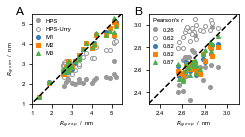

In [6]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(3.5,1.8))
cm = ['#999999', '#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))

for l,c,m,marker in zip(['HPS','HPS-Urry','M1','M2','M3'],[0,0,1,2,3],
            ['10_HPS','Urry','5_M1','2_M2','2_M3'],['o','o','o','s','^']):
    p = pd.read_pickle('optimization/{:s}/o1_init_proteinsRgs.pkl'.format(m))
    pA1 = pd.read_pickle('optimization/{:s}/o1_init_A1.pkl'.format(m))
    mfc = 'w' if l=='HPS-Urry' else cm[c]
    ax2.plot(pA1.Rg,pA1.simRg,marker=marker,ms=4,lw=0,color=cm[c],
            label='{:.2f}'.format(pearsonr(pA1.Rg,pA1.simRg)[0]), mfc=mfc)
    ax1.plot(p.expRg,p.Rg,marker=marker,ms=4,label=l,lw=0,color=cm[c], mfc=mfc)


x = np.linspace(2,3.3,100)
ax2.plot(x,x,ls='--',color='k')
ax2.set_aspect('equal')
ax2.set_xlabel(r'$R_{g,exp}$  /  nm')
ax2.set_xlim(2.3,3.1)
ax2.set_xticks(np.arange(2.4,3.1,.2))
ax2.set_ylim(2.3,3.1)

ax1.set_ylabel(r'$R_{g,sim}$  /  nm')
x = np.linspace(1.1,5.6,100)
ax1.plot(x,x,ls='--',color='k')
ax1.set_aspect('equal')
ax1.set_xlabel(r'$R_{g,exp}$  /  nm')
ax1.set_xlim(1,5.5)
ax1.set_xticks(range(1,6))
ax1.set_ylim(1,5.5)
ax1.legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.01,0.5))
leg = ax2.legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.01,.4),title=r"Pearson's $r$")
leg._legend_box.align = "left"
fig.text(0.07, .92, 'A', fontsize=12)
fig.text(0.545, .92, 'B', fontsize=12)
plt.tight_layout(pad=1.5)
plt.savefig('figures/Fig4.pdf')

<a id='S12'></a>

### Fig. S12

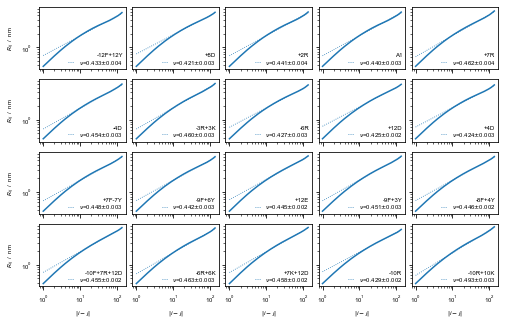

In [7]:
sequences = ['M12FP12Y', 'P8D', 'P2R', 'A1', 'P7R', 'M4D', 'M3RP3K',
       'M6R', 'P12D', 'P4D', 'P7FM7Y', 'M9FP6Y', 'P12E', 'M9FP3Y', 'M8FP4Y',
       'M10FP7RP12D', 'M6RP6K', 'P7KP12D', 'M10R', 'M10RP10K']
names = [a.replace('M','-').replace('P','+') for a in sequences]
ms = ['nu','nuE','NCPR']
df_nu = pd.DataFrame(columns=ms,index=sequences)
df_residues = pd.read_csv('residues.csv').set_index('one')

len(sequences)
proteins = pd.read_pickle('optimization/5_M1/proteinsRgs.pkl')

fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(7,4.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
pA1 = pd.read_pickle('optimization/5_M1/o1_init_A1.pkl')
R01_list = []
R02_list = []
for seq,ax,name in zip(sequences,axes.flatten(),names):
    ij,dij = pA1.loc[seq,['ij','dij']]
    f = lambda x,R0,v : R0*np.power(x,v)
    popt1, pcov1 = curve_fit(f,ij[ij<=10],dij[ij<=10],p0=[.4,.5])
    popt2, pcov2 = curve_fit(f,ij[ij>10],dij[ij>10],p0=[.4,.5])
    R01, v1, R02, v2 = popt1[0], popt1[1], popt2[0], popt2[1]
    ax.plot(ij,dij,color='tab:blue')
    R01_list.append(R01)
    R02_list.append(R02)
    s = np.linspace(ij.min(),ij.max(),100)
    v2E = np.sqrt(np.diag(pcov2))[1]
    ax.plot(s,f(s, R02, v2),label=r'$\nu$={:.3f}$\pm${:.3f}'.format(v2,v2E),lw=.8,color='tab:blue',ls=':')
    df_nu.loc[seq,'nu'] = v2
    df_nu.loc[seq,'nuE'] = v2E
    N = len(proteins.loc[seq,'fasta'])
    df_residues.loc['H','q'] = 1. / ( 1 + 10**(proteins.loc[seq,'pH']-6) )
    df_nu.loc[seq,'NCPR'] = np.array([df_residues.loc[aa].q for aa in proteins.loc[seq,'fasta']]).mean()

    leg = ax.legend(frameon=False,title=name,
                    handlelength=1,borderpad=0,loc='lower right',
                    labelspacing=.05)
    leg._legend_box.align = "right"
for i in [0,5,10,15]:
    axes.flatten()[i].set_ylabel('$R_{ij}$  /  nm')
for i in range(15,20):
    axes.flatten()[i].set_xlabel('$|i-j|$')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout(w_pad=.5)  
plt.savefig('figures/Rij.pdf')
plt.show()

<a id='S11'></a>

### Fig. S11

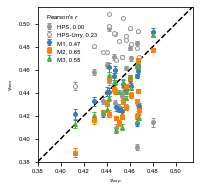

In [8]:
plt.figure(figsize=(2.8,2.8))

for l,c,m,marker in zip(['HPS','HPS-Urry','M1','M2','M3'],[0,0,1,2,3],
            ['10_HPS','Urry','5_M1','2_M2','2_M3'],['o','o','o','s','^']):
    p = pd.read_pickle('optimization/{:s}/o1_init_proteinsRgs.pkl'.format(m))
    pA1 = pd.read_pickle('optimization/{:s}/o1_init_A1.pkl'.format(m))
    mfc = 'w' if l=='HPS-Urry' else cm[c]
    plt.errorbar(pA1.Nu, pA1.simNu, yerr=pA1.simNuE, marker=marker,ms=4,
            label=l+', {:.2f}'.format(pearsonr(pA1.Nu,pA1.simNu)[0]),
            lw=0,color=cm[c],elinewidth=1, capsize=2, capthick=1, mfc=mfc)

plt.ylabel(r'$\nu_{sim}$')
x = np.linspace(.38,.515,100)
plt.plot(x,x,ls='--',color='k')
plt.xlim(.38,.515)
plt.ylim(.38,.515)
plt.gca().set_aspect('equal')
plt.xlabel(r'$\nu_{exp}$')

leg = plt.legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.04,.63),title=r"Pearson's $r$")
leg._legend_box.align = "left"

plt.tight_layout(pad=1.5)
plt.savefig('figures/A1_LCD_Nu.pdf')

<a id='5'></a>

### Fig. 5

FUS, tau_c (ns) @ min chi2
M3     7.0
M2    12.0
M1    17.0
dtype: float64
A2, tau_c (ns) @ min chi2
M3    15.0
M2    18.0
M1    17.0
dtype: float64


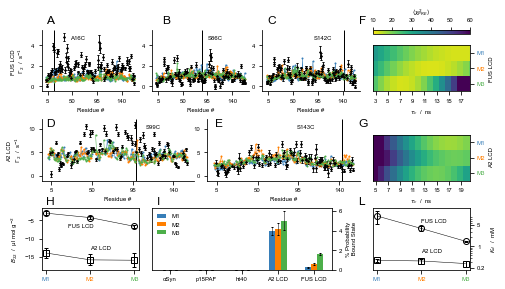

In [9]:
cm = ['#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00','#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))

fig = plt.figure(figsize=(7,4))
ax1 = plt.subplot2grid( (3,16), (0,0), rowspan=1, colspan=4 )
ax2 = plt.subplot2grid( (3,16), (0,4), rowspan=1, colspan=4 )
ax3 = plt.subplot2grid( (3,16), (0,8), rowspan=1, colspan=4 )
ax4 = plt.subplot2grid( (3,16), (0,12), rowspan=1, colspan=4 )
ax5 = plt.subplot2grid( (3,16), (1,0), rowspan=1, colspan=6 )
ax6 = plt.subplot2grid( (3,16), (1,6), rowspan=1, colspan=6 )
ax7 = plt.subplot2grid( (3,16), (1,12), rowspan=1, colspan=4 )
ax8 = plt.subplot2grid( (3,16), (2,0), rowspan=1, colspan=4 )
ax9 = plt.subplot2grid( (3,16), (2,4), rowspan=1, colspan=7 )
ax10 = plt.subplot2grid( (3,16), (2,12), rowspan=1, colspan=4 )
up = [ax4,ax1,ax2,ax3]
middle = [ax7,ax5,ax6]
down = [ax8,ax9,ax10]

FUS = pd.read_pickle('two-chain/data/chi2_FUS_tc.pkl').astype(float)[['M3','M2','M1']].T*10
print('FUS, tau_c (ns) @ min chi2')
print(FUS.idxmin(axis=1))
im = up[0].pcolor(FUS,cmap=plt.cm.viridis_r,vmin=10,vmax=60)
divider = make_axes_locatable(up[0])
cax1 = divider.new_vertical(size="10%", pad=.15)
fig.add_axes(cax1)
plt.colorbar(im, cax=cax1, orientation="horizontal", label=r'$\langle \chi^2_{PRE} \rangle$')
cax1.xaxis.set_ticks_position('top')
cax1.xaxis.set_label_position('top')
up[0].set_ylabel('FUS LCD')

A2 = pd.read_pickle('two-chain/data/chi2_A2_tc.pkl').astype(float)[['M3','M2','M1']].T*10
print('A2, tau_c (ns) @ min chi2')
print(A2.idxmin(axis=1))
im = middle[0].pcolor(A2,cmap=plt.cm.viridis_r,vmin=10,vmax=60)
divider = make_axes_locatable(middle[0])
cax2 = divider.new_vertical(size="10%", pad=.15)
fig.add_axes(cax2)
cax2.axis('off')
middle[0].set_ylabel('A2 LCD')

up[0].set_yticks(np.arange(.5,FUS.shape[0],1))
up[0].set_yticklabels(['M3','M2','M1'])
middle[0].set_yticks(np.arange(.5,FUS.shape[0],1))
middle[0].set_yticklabels(['M3','M2','M1'])
up[0].set_xticks(np.arange(.5,FUS.shape[1],2))
up[0].set_xticklabels(np.arange(3,FUS.shape[1]+3,2))
middle[0].set_xticks(np.arange(.5,A2.shape[1],2))
middle[0].set_xticklabels(np.arange(5,A2.shape[1]+5,2))
up[0].set_xlabel(r'$\tau_c$  /  ns')
middle[0].set_xlabel(r'$\tau_c$  /  ns')
up[0].set_xlim(0,16)
middle[0].set_xlim(0,16)

protein = pd.read_pickle('two-chain/data/FUS_PREs.pkl')
for ax,label,aa,delta in zip(up[1:4],[16,86,142],['A','S','S'],[30,10,-55]):
    ax.vlines(label,-.5,5.5,lw=1,color='k')
    plotInterPREdata(ax,'M1',label,protein,0)
    plotInterPREdata(ax,'M2',label,protein,1)
    plotInterPREdata(ax,'M3',label,protein,2)
    ax.set_ylim(-.5,5.5)
    ax.set_xticks(np.arange(5,180,45))
    ax.set_xlabel('Residue #')
    ax.annotate(aa+str(label)+'C',xy=(label+delta,4.6),color='k')
protein = pd.read_pickle('two-chain/data/A2_PREs.pkl')    
for ax,label,aa,delta in zip(middle[1:3],[99,143],['S','S'],[10,-50]):
    ax.vlines(label,-1,12,lw=1,color='k')
    plotInterPREdata(ax,'M1',label,protein,0)
    plotInterPREdata(ax,'M2',label,protein,1)
    plotInterPREdata(ax,'M3',label,protein,2)
    ax.set_ylim(-1,12)
    ax.set_xticks(np.arange(5,180,45))
    ax.set_xlabel('Residue #')
    ax.annotate(aa+str(label)+'C',xy=(label+delta,10),color='k')
up[1].set_ylabel('FUS LCD \n $\Gamma_2$  /  s$^{-1}$')
middle[1].set_ylabel('A2 LCD \n $\Gamma_2$  /  s$^{-1}$')
 
up[0].yaxis.set_ticks_position('right'); up[0].yaxis.set_label_position('right')
middle[0].yaxis.set_ticks_position('right'); middle[0].yaxis.set_label_position('right')

down[1].yaxis.set_ticks_position('right'); down[1].yaxis.set_label_position('right')
down[2].yaxis.set_ticks_position('right'); down[2].yaxis.set_label_position('right')

B22KdpB_A2 = pd.read_pickle('two-chain/data/dfB22KdpB_A2.pkl')
B22KdpB_FUS = pd.read_pickle('two-chain/data/dfB22KdpB_FUS.pkl')

down[0].errorbar(B22KdpB_FUS.index,B22KdpB_FUS.B22,yerr=B22KdpB_FUS.B22_E, color='k', lw=.5, marker='o',
          ms=6, elinewidth=1, capsize=2, capthick=1, mfc='none') 
down[0].errorbar(B22KdpB_A2.index,B22KdpB_A2.B22,yerr=B22KdpB_A2.B22_E, color='k', lw=.5, marker='s', 
        ms=6, elinewidth=1, capsize=2, capthick=1, mfc='none') 

down[2].errorbar(B22KdpB_FUS.index,B22KdpB_FUS.Kd,yerr=B22KdpB_FUS.Kd_E, color='k', lw=.5, marker='o',
          ms=6, elinewidth=1, capsize=2, capthick=1, mfc='none') 
down[2].errorbar(B22KdpB_A2.index,B22KdpB_A2.Kd,yerr=B22KdpB_A2.Kd_E, color='k', lw=.5, marker='s', 
        ms=6, elinewidth=1, capsize=2, capthick=1, mfc='none') 

down[2].set_yscale('log')

down[0].set_ylabel('$B_{22}$  /  µl mol g$^{-2}$')
down[1].set_ylabel('% Probability\n Bound State')
down[2].set_ylabel('$K_d$  /  mM')
down[0].annotate('A2 LCD',xy=(1,-13),color='k')
down[0].annotate('FUS LCD',xy=(.5,-7),color='k')
down[2].annotate('A2 LCD',xy=(1,.6),color='k')
down[2].annotate('FUS LCD',xy=(1,6),color='k')

pB = pd.read_pickle('two-chain/data/pB_values.pkl')
pB_E = pd.read_pickle('two-chain/data/pB_errors.pkl')

pB.plot.bar(ax=down[1],yerr=pB_E,error_kw=dict(ecolor='black',elinewidth=0.5,capsize=1))

down[1].legend(frameon=False,handlelength=1.5)
down[1].set_xticks(range(pB.index.size))
down[1].set_xticklabels(['αSyn', 'p15PAF', 'ht40', 'A2 LCD', 'FUS LCD'],rotation=0)

down[2].set_yticks([.2,1,5])
down[2].set_yticklabels([.2,1,5])

for ticklabel, tickcolor in zip(up[0].get_yticklabels(), cm[:3][::-1]):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(middle[0].get_yticklabels(), cm[:3][::-1]):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(down[0].get_xticklabels(), cm[:3]):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(down[2].get_xticklabels(), cm[:3]):
    ticklabel.set_color(tickcolor)

for ax in up[1:]+middle[1:]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
 
fig.text(0.09, .92, 'A', fontsize=12)
fig.text(0.32, .92, 'B', fontsize=12)
fig.text(0.53, .92, 'C', fontsize=12)
fig.text(0.71, .92, 'F', fontsize=12)
fig.text(0.09, .56, 'D', fontsize=12)
fig.text(0.425, .56, 'E', fontsize=12)
fig.text(0.71, .56, 'G', fontsize=12)
fig.text(0.09, .29, 'H', fontsize=12)
fig.text(0.31, .29, 'I', fontsize=12)
fig.text(0.71, .29, 'L', fontsize=12)

fig.tight_layout(h_pad=.5,w_pad=-2)
plt.savefig('figures/Fig5.png',dpi=300)

<a id='6'></a>

### Fig. 6

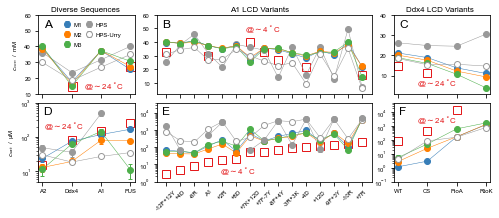

In [41]:
cm = ['#999999', '#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value.pkl')
rho_dense_e = pd.read_pickle('multi-chain/data/rho_dense_error.pkl')

fig = plt.figure(figsize=(7,3))
ax1 = plt.subplot2grid( (2,4), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (2,4), (0,1), rowspan=1, colspan=2 )
ax3 = plt.subplot2grid( (2,4), (0,3), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (2,4), (1,0), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (2,4), (1,1), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (2,4), (1,3), rowspan=1, colspan=1 )

variants = ['A2','Ddx4WT','A1','FUS'] 
names1 = ['A2','Ddx4','A1','FUS']
ms = ['HPS_den','M1_den','M2_den','M3_den']
rho_dense_v.loc[variants,ms].plot(ax=ax1,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)
ms = ['Urry_den']
rho_dense_v.loc[variants,ms].plot(ax=ax1,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w')
ms = ['HPS_dil','M1_dil','M2_dil','M3_dil']
rho_dense_v.loc[:,ms] = rho_dense_v.loc[:,ms].applymap(lambda x : np.nan if x < 1 else x)
rho_dense_v.loc[variants,ms].plot(ax=ax4,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)
ms = ['Urry_den'] 
rho_dense_v.loc[variants,ms].plot(ax=ax4,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w')
ax1.plot(['A2','Ddx4','A1','FUS'],np.array([0,14.8,0,27.8]),color=cm[4],
         lw=0,marker='s',ms=9,mfc='none')
ax4.plot(variants,np.array([15.,79.,144.,250.]),color=cm[4],lw=0,marker='s',ms=8,mfc='none')
ax4.set_yscale('log')

variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','P7KP12D','P7FM7Y','M8FP4Y','M3RP3K',
            'M4D','P12D','M9FP3Y','M10R','P7R'] 
names2 = [a.replace('M','-').replace('P','+') for a in variants]
rho_dense_v.loc[variants,'Exp'] = [2.8,4.5,7.7,13.3,19.0,20.4,49.6,52.2,68.6,88.7,96.6,110.8,131.5,150.8,198.3]
ms = ['HPS_den','M1_den','M2_den','M3_den']
rho_dense_v.loc[variants,ms].plot(ax=ax2,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)
ms = ['Urry_den']
rho_dense_v.loc[variants,ms].plot(ax=ax2,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w')
ms = ['M1_dil','M2_dil','M3_dil']
rho_dense_v.loc[variants,ms].plot(ax=ax5,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1, color=cm[1:4])
ms = ['Urry_dil']
rho_dense_v.loc[variants,ms].plot(ax=ax5,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w') 
ms = ['HPS_dil']
rho_dense_v.loc[['M6R','P8D','M10R'],ms] = np.nan
rho_dense_e.loc[['M6R','P8D','M10R'],ms] = np.nan
rho_dense_v.loc[variants,ms].plot(ax=ax5,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0])
ax2.plot(variants,[33, -10, -10, 30, -10, -10, 40, 33, 27, -10, 22, -10, -10, -10, 16],
         color=cm[4],lw=0,marker='s',ms=8,mfc='none')
ax5.plot(variants,rho_dense_v.loc[variants,'Exp'],color=cm[4],lw=0,marker='s',ms=8,mfc='none')
ax5.set_yscale('log')

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value_297.pkl')
rho_dense_e = pd.read_pickle('multi-chain/data/rho_dense_error_297.pkl')
names3 = ['WT','CS','FtoA','RtoK']
ms = ['HPS_dil','M1_dil','M2_dil','M3_dil']
rho_dense_v.loc[:,ms] = rho_dense_v.loc[:,ms].applymap(lambda x : np.nan if x < 0.01 else x)
ms = ['HPS_den','M1_den','M2_den','M3_den']
rho_dense_v.loc[:,ms].plot(ax=ax3,yerr=rho_dense_e.loc[:,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)
ms = ['Urry_den'] 
rho_dense_v.loc[:,ms].plot(ax=ax3,yerr=rho_dense_e.loc[:,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w')
ms = ['M1_dil','M2_dil','M3_dil']
rho_dense_v.loc[:,ms].plot(ax=ax6,yerr=rho_dense_e.loc[:,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1, color=cm[1:4])
ms = ['Urry_dil'] 
rho_dense_v.loc[:,ms].plot(ax=ax6,yerr=rho_dense_e.loc[:,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1,color=cm[0],
                                  mfc='w')
ax3.plot(['Ddx4WT','Ddx4CS'],np.array([14.8,11.3]),color=cm[4],
         lw=0,marker='s',ms=8,mfc='none')
ax6.plot(['Ddx4WT','Ddx4CS','Ddx4FA'],
                 np.array([2/25411.92,12/25193.64,350/24346.38])*1e6,
                 color=cm[4],lw=0,marker='s',ms=8,mfc='none')
ax6.set_yscale('log')

for ax,names in zip([ax1,ax2,ax3],[names1,names2,names3]):
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels([])
for ax,names in zip([ax4,ax6],[names1,names3]):
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names)
    
ax5.set_xticks(range(len(names2)))
ax5.set_xticklabels(names2,rotation=45)
    
for ax in [ax1]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[1:-1]+handles[:1]+handles[4:],['M1','M2','M3','HPS','HPS-Urry'],
              frameon=False,ncol=2,loc=(.26,.56),
              borderaxespad=.5,labelspacing=.8,handlelength=.5,columnspacing=1)
for ax in [ax2,ax4,ax5]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,[],frameon=False,ncol=2,borderaxespad=.5,
                  labelspacing=.8,handlelength=.5)
for ax in [ax3,ax6]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,[],frameon=False,ncol=1,borderaxespad=.5,
                  labelspacing=.8,handlelength=.5,loc='lower right')
    
ax1.set_ylim(10,60)
ax2.set_ylim(2,60)
ax3.set_ylim(1,40)
ax4.set_ylim(5,1e3)
ax5.set_ylim(1,4e4)
ax6.set_ylim(.1,5e4)

ax1.set_ylabel('$c_{con}$  /  mM')
ax4.set_ylabel('$c_{sat}$  /  µM')
fig.text(0.105, .965, 'Diverse Sequences', fontsize=8)
fig.text(0.46, .965, 'A1 LCD Variants', fontsize=8)
fig.text(0.81, .965, 'Ddx4 LCD Variants', fontsize=8)


fig.text(0.17, .605, '@$\sim$24$^\circ$C', fontsize=8,color=cm[4])
fig.text(0.49, .87, '@$\sim$4$^\circ$C', fontsize=8,color=cm[4])
fig.text(0.83, .62, '@$\sim$24$^\circ$C', fontsize=8,color=cm[4])

fig.text(0.09, .42, '@$\sim$24$^\circ$C', fontsize=8,color=cm[4])
fig.text(0.44, .21, '@$\sim$4$^\circ$C', fontsize=8,color=cm[4])
fig.text(0.83, .45, '@$\sim$24$^\circ$C', fontsize=8,color=cm[4])

fig.text(0.09, .89, 'A', fontsize=12)
fig.text(0.325, .89, 'B', fontsize=12)
fig.text(0.795, .89, 'C', fontsize=12)
fig.text(0.09, .49, 'D', fontsize=12)
fig.text(0.325, .49, 'E', fontsize=12)
fig.text(0.795, .49, 'F', fontsize=12)

fig.tight_layout(pad=1.5,w_pad=.3,h_pad=.1)
plt.savefig('figures/Fig6.pdf')

Load energy maps

In [11]:
p = pd.read_pickle('optimization/M1.pkl')
pA1NLS = pd.read_pickle('optimization/A1NLS.pkl')
proteins = pd.read_pickle('multi-chain/proteins.pkl')

indices = [i for i in combinations(range(137),2)]
M4D_1 = pd.DataFrame(index=range(137),columns=range(137),dtype=float)
for k,(i,j) in enumerate(indices):
    M4D_1.loc[i,j] = p.loc['M4D','map'][k]
    M4D_1.loc[j,i] = p.loc['M4D','map'][k]
P4D_1 = pd.DataFrame(index=range(137),columns=range(137),dtype=float)
for k,(i,j) in enumerate(indices):
    P4D_1.loc[i,j] = p.loc['P4D','map'][k]
    P4D_1.loc[j,i] = p.loc['P4D','map'][k]
P8D_1 = pd.DataFrame(index=range(137),columns=range(137),dtype=float)
for k,(i,j) in enumerate(indices):
    P8D_1.loc[i,j] = p.loc['P8D','map'][k]
    P8D_1.loc[j,i] = p.loc['P8D','map'][k]
A1_1 = pd.DataFrame(index=range(137),columns=range(137),dtype=float)
for k,(i,j) in enumerate(indices):
    A1_1.loc[i,j] = p.loc['A1','map'][k]
    A1_1.loc[j,i] = p.loc['A1','map'][k]
A1NLS_1 = pd.DataFrame(index=range(137),columns=range(137),dtype=float)
for k,(i,j) in enumerate(indices):
    A1NLS_1.loc[i,j] = pA1NLS.loc['A1NLS','map'][k]
    A1NLS_1.loc[j,i] = pA1NLS.loc['A1NLS','map'][k]
    
N = len(proteins.loc['A2'].fasta)
indices = [i for i in combinations(range(N),2)]
A2_1 = pd.DataFrame(index=range(N),columns=range(N),dtype=float)
for k,(i,j) in enumerate(indices):
    A2_1.loc[i,j] = p.loc['A2','map'][k]
    A2_1.loc[j,i] = p.loc['A2','map'][k]
N = len(proteins.loc['FUS'].fasta)
indices = [i for i in combinations(range(N),2)]
FUS_1 = pd.DataFrame(index=range(N),columns=range(N),dtype=float)
for k,(i,j) in enumerate(indices):
    FUS_1.loc[i,j] = p.loc['FUS','map'][k]
    FUS_1.loc[j,i] = p.loc['FUS','map'][k]

N = len(proteins.loc['A2'].fasta)
A2_M1 = np.zeros((N,N))
A2_M2 = np.zeros((N,N))
A2_M3 = np.zeros((N,N))
for i in range(1,11):
    A2_M1 += np.load('two-chain/data/maps/A2_10_{:d}_map.npy'.format(i)).T / 10
    A2_M2 += np.load('two-chain/data/maps/A2_50_{:d}_map.npy'.format(i)).T / 10
    A2_M3 += np.load('two-chain/data/maps/A2_60_{:d}_map.npy'.format(i)).T / 10
N = len(proteins.loc['FUS'].fasta)
FUS_M1 = np.zeros((N,N))
FUS_M2 = np.zeros((N,N))
FUS_M3 = np.zeros((N,N))
for i in range(1,11):
    FUS_M1 += np.load('two-chain/data/maps/FUS_10_{:d}_map.npy'.format(i)).T / 10
    FUS_M2 += np.load('two-chain/data/maps/FUS_50_{:d}_map.npy'.format(i)).T / 10
    FUS_M3 += np.load('two-chain/data/maps/FUS_60_{:d}_map.npy'.format(i)).T / 10

M4D_multi = np.load('multi-chain/data/M1/maps/M4D_323_ecmap.npy').T
P8D_multi = np.load('multi-chain/data/M1/maps/P8D_323_ecmap.npy').T
P4D_multi = np.load('multi-chain/data/M1/maps/P4D_323_ecmap.npy').T
A1_multi = np.load('multi-chain/data/M1/maps/A1_323_ecmap.npy').T
A1NLS_multi = np.load('multi-chain/data/M1/maps/A1NLS_323_ecmap.npy').T
A2_multi = np.load('multi-chain/data/M1/maps/A2_323_ecmap.npy').T
FUS_multi = np.load('multi-chain/data/M1/maps/FUS_323_ecmap.npy').T

<a id='7'></a>

### Fig. 7

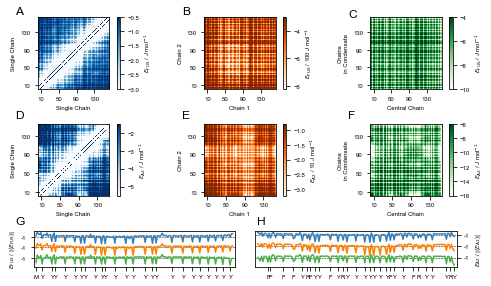

In [12]:
f = plt.figure(figsize=(7,4))
ax1 = plt.subplot2grid( (8,8), (0,0), rowspan=3, colspan=2 )
ax2 = plt.subplot2grid( (8,8), (0,3), rowspan=3, colspan=2 )
ax3 = plt.subplot2grid( (8,8), (0,6), rowspan=3, colspan=2 )
ax4 = plt.subplot2grid( (8,8), (3,0), rowspan=3, colspan=2 )
ax5 = plt.subplot2grid( (8,8), (3,3), rowspan=3, colspan=2 )
ax6 = plt.subplot2grid( (8,8), (3,6), rowspan=3, colspan=2 )
ax7 = plt.subplot2grid( (8,8), (6,0), rowspan=2, colspan=4 )
ax8 = plt.subplot2grid( (8,8), (6,4), rowspan=2, colspan=4 )

cm = [ '#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00']
plt.rc('axes', prop_cycle = cycler('color', cm))

up = [ax1,ax2,ax3]
middle = [ax4,ax5,ax6]
down = [ax7,ax8]

plotMap(up[0],FUS_1,r'$E_{\mathrm{FUS}}$ / J mol$^{-1}$',-3,-.5,cmap=plt.cm.Blues)
plotMap(up[1],FUS_M1*1e2,r'$E_{\mathrm{FUS}}$ / 100 J mol$^{-1}$',-8.2,-3,cmap=plt.cm.Oranges,
        xlabel='Chain 1',ylabel='Chain 2')
plotMap(up[2],FUS_multi,r'$E_{\mathrm{FUS}}$ / J mol$^{-1}$',-10,-4,cmap=plt.cm.Greens,xlabel='Central Chain',
        ylabel='Chains\nin Condensate')
plotMap(middle[0],A2_1,r'$E_{\mathrm{A2}}$ / J mol$^{-1}$',-5.5,-1.5,cmap=plt.cm.Blues)
plotMap(middle[1],A2_M1*10,r'$E_{\mathrm{A2}}$ / 10 J mol$^{-1}$',-3.2,-.8,cmap=plt.cm.Oranges,
        xlabel='Chain 1',ylabel='Chain 2')
plotMap(middle[2],A2_multi,r'$E_{\mathrm{A2}}$ / J mol$^{-1}$',-16,-6,cmap=plt.cm.Greens,
        xlabel='Central Chain',ylabel='Chains\nin Condensate')

FUS_s1 = np.nansum(np.where(np.triu(np.ones(FUS_1.shape),k=3).astype(bool),FUS_1.values,np.nan),axis=0)
FUS_s2 = np.nansum(np.where(np.tril(np.ones(FUS_1.shape),k=-3).astype(bool),FUS_1.values,np.nan),axis=0)
FUS_s = (FUS_s1 + FUS_s2)

ax7.plot(FUS_s/abs(np.nanmean(FUS_s))+4,color=cm[0])
ax7.plot(FUS_M1.sum(axis=0)/abs(np.nanmean(FUS_M1.sum(axis=0)))+2,color=cm[1])
ax7.plot(FUS_multi.sum(axis=0)/abs(np.nanmean(FUS_multi.sum(axis=0))),color=cm[2])

A2_s1 = np.nansum(np.where(np.triu(np.ones(A2_1.shape),k=3).astype(bool),A2_1.values,np.nan),axis=0)
A2_s2 = np.nansum(np.where(np.tril(np.ones(A2_1.shape),k=-3).astype(bool),A2_1.values,np.nan),axis=0)
A2_s = (A2_s1 + A2_s2)

ax8.plot(A2_s/abs(np.nanmean(A2_s))+4,color=cm[0])
ax8.plot(A2_M1.sum(axis=0)/abs(np.nanmean(A2_M1.sum(axis=0)))+2,color=cm[1])
ax8.plot(A2_multi.sum(axis=0)/abs(np.nanmean(A2_multi.sum(axis=0))),color=cm[2])

ax7.set_ylabel(r'$E_{\mathrm{FUS}}$ / $|\langle E_{\mathrm{FUS}} \rangle|$')
ax8.set_ylabel(r'$E_{\mathrm{A2}}$ / $|\langle E_{\mathrm{A2}} \rangle|$')

ticks = np.arange(0,len(proteins.loc['FUS'].fasta),1)
ax7.hlines([-1,1,3],ticks.min()-2,ticks.max()+2,ls='--',color='k',lw=.5)
ax7.set_xlim(ticks.min()-2,ticks.max()+2)
boolFUS = [e<np.quantile(FUS_multi.mean(axis=1),.16) for e in FUS_multi.mean(axis=1)]
boolFUS[-2] = False
xticks = ticks[boolFUS]
xlabels = np.array(proteins.loc['FUS'].fasta)[boolFUS]
ax7.set_xticks(xticks)
ax7.set_xticklabels(xlabels)

ticks = np.arange(0,len(proteins.loc['A2'].fasta),1)
ax8.hlines([-1,1,3],ticks.min()-2,ticks.max()+2,ls='--',color='k',lw=.5)
ax8.set_xlim(ticks.min()-2,ticks.max()+2)
boolA2 = [e<np.quantile(A2_multi.mean(axis=1),.2) for e in A2_multi.mean(axis=1)]
boolA2[-2] = False
boolA2[128] = False
xticks = ticks[boolA2]
xlabels = np.array(proteins.loc['A2'].fasta)[boolA2]
ax8.set_xticks(xticks)
ax8.set_xticklabels(xlabels)

ax8.yaxis.set_ticks_position('right'); ax8.yaxis.set_label_position('right')

ax7.set_yticks([-1,1,3])
ax7.set_yticklabels([-1,-1,-1])
ax8.set_yticks([-1,1,3])
ax8.set_yticklabels([-1,-1,-1])

for ax in up+middle:
    ax.set_xticks(np.arange(9,160,40))
    ax.set_xticklabels(np.arange(10,160,40))
    ax.set_yticks(np.arange(9,160,40))
    ax.set_yticklabels(np.arange(10,160,40))

f.text(0.04, .96, 'A', fontsize=12)
f.text(0.37, .96, 'B', fontsize=12)
f.text(0.7, .95, 'C', fontsize=12)
f.text(0.04, .6, 'D', fontsize=12)
f.text(0.37, .6, 'E', fontsize=12)
f.text(0.7, .6, 'F', fontsize=12)
f.text(0.04, .23, 'G', fontsize=12)
f.text(0.52, .23, 'H', fontsize=12)

f.tight_layout(w_pad=-2,pad=2)    
f.savefig('figures/Fig7.png',dpi=300)
plt.show()

<a id='8'></a>

### Fig. 8

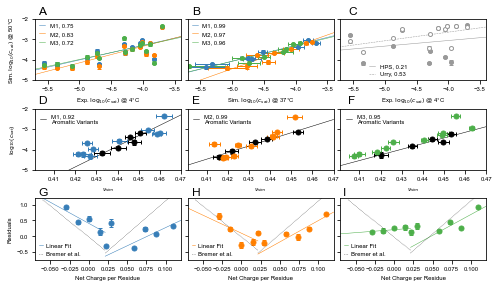

In [13]:
fig, (up,middle,down) = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(7,4))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

cm = [ '#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00']
plt.rc('axes', prop_cycle = cycler('color', cm))

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value.pkl')
rho_dense_e = pd.read_pickle('multi-chain/data/rho_dense_error.pkl')
variants = ['M12FP12Y','P4D','M6R','A1','P2R','P8D','P7KP12D','P7FM7Y','M8FP4Y','M3RP3K',
            'M4D','P12D','M9FP3Y','M10R','P7R'] 
rho_dense_v.loc[variants,'Exp'] = [2.8,4.5,7.7,13.3,19.0,20.4,49.6,52.2,68.6,88.7,96.6,110.8,131.5,150.8,198.3]
rho_dense_e.loc[variants,'Exp'] = 1

ms = ['M1_dil','M2_dil','M3_dil','Exp','HPS_dil','Urry_dil',]
rho_dense_e.loc[variants,ms] = 0.434*rho_dense_e.loc[variants,ms]/rho_dense_v.loc[variants,ms]
rho_dense_v.loc[variants,ms] = rho_dense_v.loc[variants,ms].applymap(lambda x : np.log10(x/1e6))

for i,(m,l) in enumerate(zip(['M1_dil','M2_dil','M3_dil'],['M1','M2','M3'])):
    pr = pearsonr(rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m])[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m])
    x = np.linspace(-5.8,-3.3,1000)
    up[0].plot(x,popt[0]*x+popt[1],ls='-',lw=.5,color=cm[i],label=l+', {:.2f}'.format(pr))
    up[0].errorbar(rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m],
             yerr=rho_dense_e.loc[variants,m],
             lw=0, marker='o', ms=4, elinewidth=1, capsize=2, capthick=1, color=cm[i])
    up[0].set_xlim(-5.7,-3.4)
    up[0].set_ylim(-5,-2)
    
rho_dense_v310 = pd.read_pickle('multi-chain/data/rho_dense_value_310.pkl')
rho_dense_e310 = pd.read_pickle('multi-chain/data/rho_dense_error_310.pkl')
variants = ['M6R','A1','P8D','P7FM7Y', 'M8FP4Y', 'M4D', 'M9FP3Y','M10R', 'P7R'] 
ms = ['M1_dil','M2_dil','M3_dil']
rho_dense_e310.loc[variants,ms] = 0.434*rho_dense_e310.loc[variants,ms]/rho_dense_v310.loc[variants,ms]
rho_dense_v310.loc[variants,ms] = rho_dense_v310.loc[variants,ms].applymap(lambda x : np.log10(x/1e6))

for i,(m,l) in enumerate(zip(['M1_dil','M2_dil','M3_dil'],['M1','M2','M3'])):
    pr = pearsonr(rho_dense_v310.loc[variants,m],rho_dense_v.loc[variants,m])[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,rho_dense_v310.loc[variants,m],rho_dense_v.loc[variants,m])
    x = np.linspace(-5.8,-3.3,1000)
    up[1].plot(x,popt[0]*x+popt[1],ls='-',lw=.5,color=cm[i],label=l+', {:.2f}'.format(pr))
    up[1].errorbar(rho_dense_v310.loc[variants,m],rho_dense_v.loc[variants,m],
             xerr=rho_dense_e310.loc[variants,m],
             yerr=rho_dense_e.loc[variants,m],
             lw=0, marker='o', ms=4, elinewidth=1, capsize=2, capthick=1, color=cm[i])
    up[1].set_xlim(-5.7,-3.4)
    up[1].set_ylim(-5,-2)
    
variants = ['M12FP12Y','P4D','A1','P2R','P7KP12D','P7FM7Y','M8FP4Y','M3RP3K',
            'M4D','P12D','M9FP3Y','P7R'] 
    
for m,l,mfc,ls in zip(['HPS_dil','Urry_dil'],['HPS','Urry'], [cm[3],'w'], ['-','--']):
    pr = pearsonr(rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m])[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m])
    x = np.linspace(-5.8,-3.3,1000)
    up[2].plot(x,popt[0]*x+popt[1],lw=.5,color=cm[3],label=l+', {:.2f}'.format(pr),ls=ls)
    up[2].errorbar(rho_dense_v.loc[variants,'Exp'],rho_dense_v.loc[variants,m],
             yerr=rho_dense_e.loc[variants,m],mfc=mfc,
             lw=0, marker='o', ms=4, elinewidth=1, capsize=2, capthick=1, color=cm[3])
    up[2].set_xlim(-5.7,-3.4)
    up[2].set_ylim(-5,-2)

aro = ['M12FP12Y','A1','P7FM7Y','M8FP4Y','M9FP3Y'] 
cha = ['M6R','P4D','P2R','P8D','P7KP12D','M3RP3K','M4D','P12D','M10R','P7R'] 


for m,l,f,c in zip(ms,['M1','M2','M3'],['5_M1','2_M2','2_M3'],range(3)):

    pA1 = pd.read_pickle('optimization/{:s}/o1_init_A1.pkl'.format(f))
    rs = pearsonr(pA1.loc[aro,'simNu'],rho_dense_v.loc[aro,m])[0]
    popt,_ = curve_fit(lambda x,a,b : a*x+b,pA1.loc[aro,'simNu'],rho_dense_v.loc[aro,m])
    x = np.linspace(.4,.47,10)
    middle[c].plot(x,popt[0]*x+popt[1],ls='-',lw=.5,
             label=l+', {:.2f}\nAromatic Variants'.format(rs),color='k')
    middle[c].errorbar(pA1.loc[aro,'simNu'],rho_dense_v.loc[aro,m],
             xerr=pA1.loc[aro,'simNuE'],yerr=rho_dense_e.loc[aro,m],
             lw=0, marker='o', ms=5, elinewidth=1, capsize=2, capthick=1,color='k')
    middle[c].errorbar(pA1.loc[cha,'simNu'],rho_dense_v.loc[cha,m],
             xerr=pA1.loc[cha,'simNuE'],yerr=rho_dense_e.loc[cha,m],
             lw=0, marker='o', ms=5, elinewidth=1, capsize=2, capthick=1,color=cm[c])

    pA1 = pd.read_pickle('optimization/{:s}/o1_init_A1.pkl'.format(f))
    residual = rho_dense_v[m]-(popt[0]*pA1['simNu']+popt[1])
    down[c].errorbar(df_nu.loc[cha,'NCPR'], residual.loc[cha],
             yerr=rho_dense_e.loc[cha,m],
             lw=0, marker='o', ms=5, elinewidth=1, capsize=2, capthick=1,color=cm[c])
    ndx1 = df_nu.loc[cha].NCPR[df_nu.NCPR<0.03].index
    popt1,_ = curve_fit(lambda x,a,b : a*x+b,df_nu.loc[ndx1,'NCPR'],residual.loc[ndx1])
    ndx2 = df_nu.loc[cha].NCPR[df_nu.NCPR>=0.03].index
    popt2,_ = curve_fit(lambda x,a,b : a*x+b,df_nu.loc[ndx2,'NCPR'],residual.loc[ndx2])
    x = np.linspace(-.07,0.0214,10)
    down[c].plot(x,popt1[0]*x+popt1[1],ls='-',lw=.5,color=cm[c])
    x = np.linspace(0.0214,.12,10)
    down[c].plot(x,popt2[0]*x+popt2[1],ls='-',lw=.5,color=cm[c],label='Linear Fit')
    x = np.linspace(-.06,0.0214,10)
    down[c].plot(x,-19.7*x-0.0273,ls=':',lw=.5,color='k')
    x = np.linspace(0.0214,.12,10)
    down[c].plot(x,21.1*x-0.989,ls=':',lw=.5,color='k',label='Bremer et al.')
    
    leg = middle[c].legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,
                 loc=(.02,.7))
    leg._legend_box.align = "left"
    
    middle[c].set_ylim(-5,-2)
    middle[c].set_xlim(.401,.47)
    down[c].set_ylim(-.75,1.2)
    down[c].set_xlim(-.07,.12)
    middle[c].set_xlabel(r'$\nu_{sim}$')
    down[c].set_xlabel(r'Net Charge per Residue')

up[0].set_ylabel('Sim. $\log_{10}(c_{sat})$ @ 50$^{\circ}$C') 
up[0].set_xlabel('Exp. $\log_{10}(c_{sat})$ @ 4$^{\circ}$C') 
up[1].set_xlabel('Sim. $\log_{10}(c_{sat})$ @ 37$^{\circ}$C') 
up[2].set_xlabel('Exp. $\log_{10}(c_{sat})$ @ 4$^{\circ}$C') 

for i in [1,2]:
    up[i].set_yticklabels([])
    middle[i].set_yticklabels([])
    down[i].set_yticklabels([])

leg = up[0].legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.01,.54))
leg._legend_box.align = "right"
leg = up[1].legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.01,.54))
leg._legend_box.align = "right"
leg = up[2].legend(frameon=False,ncol=1,handlelength=1,columnspacing=1.4,loc=(.18,.01))
leg._legend_box.align = "right"

for i in [0,1,2]:
    leg = down[i].legend(frameon=False,ncol=1,handlelength=.6,handletextpad=.5,
                         columnspacing=1.4,loc=(.01,.01))
    leg._legend_box.align = "left"

middle[0].set_ylabel('$\log_{10}(c_{sat})$')
down[0].set_ylabel('Residuals')

fig.text(0.085, .965, 'A', fontsize=12)
fig.text(0.39, .965, 'B', fontsize=12)
fig.text(0.7, .965, 'C', fontsize=12)
fig.text(0.085, .655, 'D', fontsize=12)
fig.text(0.39, .655, 'E', fontsize=12)
fig.text(0.7, .655, 'F', fontsize=12)
fig.text(0.085, .338, 'G', fontsize=12)
fig.text(0.39, .338, 'H', fontsize=12)
fig.text(0.69, .338, 'I', fontsize=12)
plt.tight_layout(w_pad=0.4,h_pad=0.1,pad=2)
plt.savefig('figures/Fig8.pdf')

<a id='S3'></a>

### Fig. S3

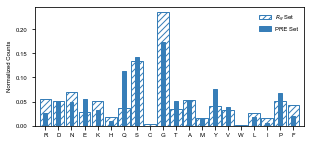

In [14]:
fig = plt.figure(figsize=(4.3,2))

r = pd.read_csv('residues.csv').set_index('one')

p = pd.read_pickle('optimization/10_5/o1_init_proteinsRgs.pkl')
aaAll = p.fasta.sum()

counts = [aaAll.count(aa) for aa in r.index]
freq = counts/np.sum(counts)
c = np.array(counts)
plt.bar(r.index,freq,width=0.9,edgecolor=cm[0],hatch = '////',color='w',
        label='$R_g$ Set')

p = pd.read_pickle('optimization/10_5/o1_init_proteins.pkl')
aaAll = p.fasta.sum()

counts = [aaAll.count(aa) for aa in r.index]
freq = counts/np.sum(counts)
c += np.array(counts)
f = c/np.sum(c)
plt.bar(r.index,freq,width=0.3,edgecolor=cm[0],color=cm[0],
        label='PRE Set')

plt.legend(frameon=False)
plt.ylabel('Normalized Counts')
plt.xlim(-.8,19.8)

plt.tight_layout()
plt.savefig('figures/sequences.pdf')
plt.show()

<a id='S3'></a>

### Fig. S20

2.3364074094740532
1.459215288319345
1.624688534415012
0.8241586047563784
0.7388801741937375
0.8237409232643182


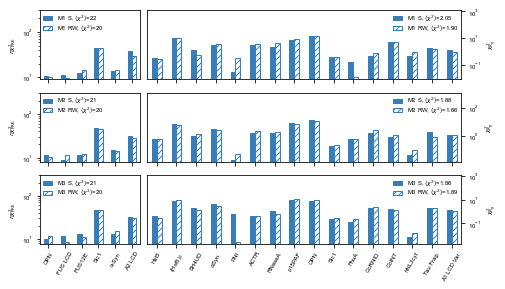

In [15]:
fig = plt.figure(figsize=(7,4))
ax1 = plt.subplot2grid( (3,4), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (3,4), (0,1), rowspan=1, colspan=3 )
ax3 = plt.subplot2grid( (3,4), (1,0), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (3,4), (1,1), rowspan=1, colspan=3 )
ax5 = plt.subplot2grid( (3,4), (2,0), rowspan=1, colspan=1 )
ax6 = plt.subplot2grid( (3,4), (2,1), rowspan=1, colspan=3 )

for ax,folder,m,dfRW in zip([ax1,ax3,ax5],['5_M1','2_M2','2_M3'],['M1','M2','M3'],[df1,df2,df3]):
    df = pd.read_pickle('optimization/'+folder+'/o1_init_proteins.pkl')
    df_pre = pd.DataFrame({r'{:s} S, $\langle \chi^2 \rangle$={:.0f}'.format(m,df.chi2_pre.mean()):df.chi2_pre,
        r'{:s} RW, $\langle \chi^2 \rangle$={:.0f}'.format(m,dfRW.loc[opt_results.loc['ndx',m]].chi2_pre.mean()):
                       dfRW.loc[opt_results.loc['ndx',m]].chi2_pre})
    df_pre.plot.bar(ax=ax,color=[cm[0],'w'],hatch='////',edgecolor=cm[0])
    print(np.abs(df_pre.iloc[:,0]-df_pre.iloc[:,1]).mean())
    ax.set_yscale('log')
    ax.set_ylim(0,300)
    ax.set_ylabel('$\eta \chi^2_{\mathrm{PRE}}$')
    ax.legend(frameon=False,ncol=1,borderaxespad=.1,
           labelspacing=-.1,loc='upper left',handlelength=1.5,columnspacing=.1)
ax5.set_xticklabels(pre_names,rotation=60)

for ax,folder,m,dfRW in zip([ax2,ax4,ax6],['5_M1','2_M2','2_M3'],['M1','M2','M3'],[df1,df2,df3]):
    df = pd.read_pickle('optimization/'+folder+'/o1_init_proteinsRgs.pkl')
    df_rg = pd.DataFrame({r'{:s} S, $\langle \chi^2 \rangle$={:.2f}'.format(m,df.chi2_rg.mean()):df.chi2_rg,
        r'{:s} RW, $\langle \chi^2 \rangle$={:.2f}'.format(m,dfRW.loc[opt_results.loc['ndx',m]].chi2_rg.mean()):
                      dfRW.loc[opt_results.loc['ndx',m]].chi2_rg})
    print(np.abs(df_rg.iloc[:,0]-df_rg.iloc[:,1]).mean())
    pd.concat((df_rg.loc[p_index],
           pd.DataFrame({'Tau Fragments':df_rg.loc[p_tau].mean(),
                         'A1 LCD Variants':df_rg.loc[p_A1].mean()}).T)).plot.bar(ax=ax,color=[cm[0],'w'],
                                                                          hatch='////',edgecolor=cm[0])
    ax.yaxis.set_label_position("right"); ax.yaxis.set_ticks_position('right')
    ax.set_yscale('log')
    ax.set_ylim(0,1200)
    ax.set_ylabel('$\chi^2_{R_g}$')
    ax.legend(frameon=False,ncol=1,borderaxespad=.1,
           labelspacing=-.1,loc='upper right',handlelength=1.5,columnspacing=.1)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticklabels([])
ax6.set_xticklabels(p_names,rotation=60)

plt.tight_layout()    
plt.savefig('figures/reweighting.pdf')

<a id='S4'></a>

### Fig. S4

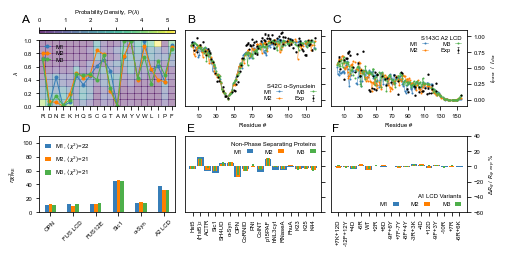

In [16]:
fig, [(ax1,ax2,ax3),(ax4,ax5,ax6)] = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(7,3.5))

dfprior = pd.read_pickle('optimization/prior.pkl')
dfparams = pd.read_csv('residues.csv').set_index('three')
im = ax1.pcolor(dfprior.T,alpha=.4)
ax1.set_xticks(np.arange(.5,20,1))
ax1.set_xticklabels(dfprior.index)
ax1.plot(np.arange(.5,20,1),dfparams.M1*10,marker='o',ms=3,lw=1,
         color=cm[0],label='M1')
ax1.plot(np.arange(.5,20,1),dfparams.M2*10,marker='o',ms=3,lw=1,
         color=cm[1],label='M2')
ax1.plot(np.arange(.5,20,1),dfparams.M3*10,marker='o',ms=3,lw=1,color=cm[2],label='M3')
ax1.set_ylabel('$\lambda$')
ax1.set_yticks(np.arange(0,1.1,.2)*10)
ax1.set_yticklabels(['{:.1f}'.format(i) for i in np.arange(0,1.1,.2)])
ax1.legend(frameon=False,loc=(.02,.63),labelspacing=.2,handlelength=1)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=.1)
fig.add_axes(cax)
plt.colorbar(im, cax=cax, orientation="horizontal", label=r'Probability Density, P($\lambda$)')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

HPS = pd.read_pickle('optimization/5_M1/o1_init_proteins.pkl')
AVG = pd.read_pickle('optimization/2_M2/o1_init_proteins.pkl')
l5 = pd.read_pickle('optimization/2_M3/o1_init_proteins.pkl')
df_pre = pd.DataFrame({r'M1, $\langle \chi^2 \rangle$={:.0f}'.format(HPS.chi2_pre.mean()):HPS.chi2_pre,
                      r'M2, $\langle \chi^2 \rangle$={:.0f}'.format(AVG.chi2_pre.mean()):AVG.chi2_pre,
                      r'M3, $\langle \chi^2 \rangle$={:.0f}'.format(l5.chi2_pre.mean()):l5.chi2_pre})
df_pre.plot.bar(ax=ax4)
ax4.set_ylim(0,110)

plotPREdata_1(ax2,'aSyn',42,HPS,0,'M1')
plotPREdata_1(ax2,'aSyn',42,AVG,1,'M2')
plotPREdata_1(ax2,'aSyn',42,l5,2,'M3')

plotPREdata_1(ax3,'A2',143,HPS,0,'M1')
plotPREdata_1(ax3,'A2',143,AVG,1,'M2')
plotPREdata_1(ax3,'A2',143,l5,2,'M3')

leg = ax2.legend(title=r'S42C α-Synuclein',frameon=False,handlelength=1,
                 markerfirst=False,ncol=2,labelspacing=.2)
leg._legend_box.align = "right"
leg = ax3.legend(title='S143C A2 LCD',frameon=False,handlelength=1,
                markerfirst=False,ncol=2,labelspacing=.2)
leg._legend_box.align = "right"
ax2.set_ylim(-.1,1.1)
ax3.set_ylim(-.1,1.1)
ax2.set_xlabel('Residue #')
ax3.set_xlabel('Residue #')
ax3.set_ylabel('$I_{para}$  /  $I_{dia}$')

solub = ['Hst5','Hst52','ACTR','Sic92','SH4UD','aSyn140','OPN220','CoRNID','PNt','ColNT','p15PAF','hNL3cyt',
'RNaseA','FhuA','K23','K25','K44']
varia = ['P7KP12D','M12FP12Y','P4D','M6R','A1','P2R','P8D','M9FP6Y','P7FM7Y','M8FP4Y',
'M3RP3K','M4D','P12D','M9FP3Y','M10R','P7R','M6RP6K']

names = ['Hst5',r'(Hst5)$_2$','ACTR','Sic1','SH4UD','α-Syn','OPN','CoRNID','PNt','ColNT','p15PAF','hNL3cyt',
'RNaseA','FhuA','K23','K25','K44']
p = pd.read_pickle('optimization/5_M1/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,0,.9,names,'M1')
p = pd.read_pickle('optimization/2_M2/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,1,.6,names,'M2')
p = pd.read_pickle('optimization/2_M3/o1_init_proteinsRgs.pkl').loc[solub]
plotErr(ax5,p,2,.3,names,'M3')

names = [a.replace('A1','WT').replace('M','-').replace('P','+') for a in varia]
p = pd.read_pickle('optimization/5_M1/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,0,.9,names,'M1')
p = pd.read_pickle('optimization/2_M2/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,1,.6,names,'M2')
p = pd.read_pickle('optimization/2_M3/o1_init_proteinsRgs.pkl').loc[varia]
plotErr(ax6,p,2,.3,names,'M3')

leg = ax5.legend(title=r'Non-Phase Separating Proteins',frameon=False,handlelength=1,
                 markerfirst=False,ncol=3)
leg._legend_box.align = "right"
leg = ax6.legend(title=r'A1 LCD Variants',frameon=False,handlelength=1,
                 markerfirst=False,ncol=3,loc='lower right')
leg._legend_box.align = "right"

ax6.set_ylabel(r'$\Delta R_g$ / $R_{g,exp}$ %')
ax2.set_yticklabels([])
ax5.set_yticklabels([])
ax5.yaxis.set_label_position("right"); ax5.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position("right"); ax6.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position("right"); ax2.yaxis.set_ticks_position('right')
ax3.yaxis.set_label_position("right"); ax3.yaxis.set_ticks_position('right')

ax4.legend(frameon=False,ncol=1,borderaxespad=.5,handlelength=1,loc='upper left')
pre_names = ['OPN', 'FUS LCD', 'FUS12E', 'Sic1', 'α-Syn', 'A2 LCD']

ax4.set_xticklabels(pre_names,rotation=45)
ax4.set_ylabel('$\eta \chi^2_{\mathrm{PRE}}$')

ax5.set_ylim(-60,40)
ax6.set_ylim(-60,40)
ax5.set_xlim(-1,17)
ax6.set_xlim(-1,17)

fig.text(0.04, .91, 'A', fontsize=12)
fig.text(0.37, .91, 'B', fontsize=12)
fig.text(0.658, .91, 'C', fontsize=12)
fig.text(0.04, .48, 'D', fontsize=12)
fig.text(0.37, .48, 'E', fontsize=12)
fig.text(0.658, .48, 'F', fontsize=12)

plt.tight_layout()
plt.savefig('figures/OPT_single.pdf')
plt.show()

<a id='S5–S10'></a>

### Fig. S5–S10

OPN
S10, E33, S64, R88, A117, D130, S144, S162, S184, S203
1.0 2.0 2.0 3.0


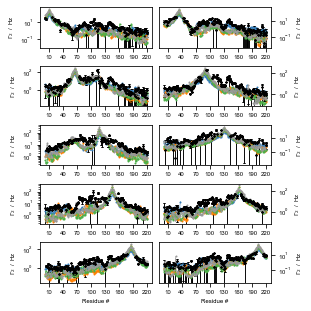

FUS
A16, S86, S142
2.0 4.0 4.0 3.0


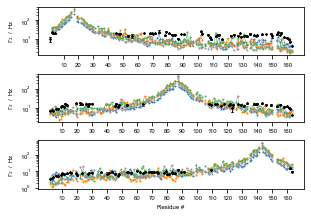

FUS12E
G16, Q86, Q142
2.0 3.0 3.0 2.0


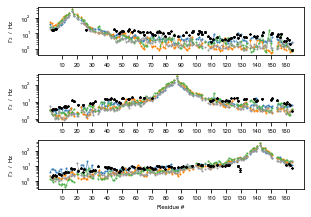

Sic1
G1, N23, S40, N66, P85, T92
2.0 2.0 2.0 2.0


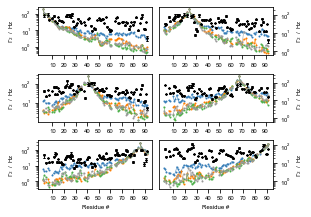

aSyn
Q24, S42, Q62, S87, N103
1.0 1.0 1.0 1.0


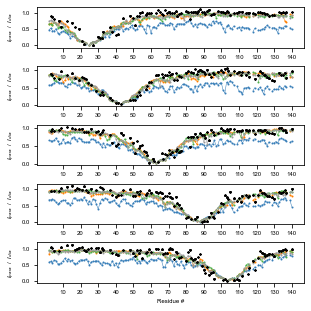

A2
S99, S143
6.0 6.0 6.0 5.0


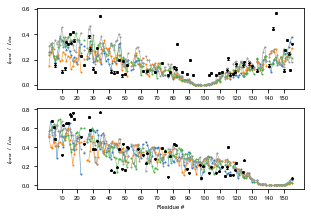

In [17]:
HPS = pd.read_pickle('optimization/10_HPS/o1_init_proteins.pkl')
M1 = pd.read_pickle('optimization/5_M1/o1_init_proteins.pkl')
M2 = pd.read_pickle('optimization/2_M2/o1_init_proteins.pkl')
M3 = pd.read_pickle('optimization/2_M3/o1_init_proteins.pkl')
for name in AVG.index:
    figsize = (4.3,3)
    labels = HPS.loc[name].labels
    cols = 1 if len(labels)<6 else 2
    rows = int(len(labels) / cols)
    if len(labels)>6 or len(labels)==5:
        figsize = (4.3,4.3)
    fig, axes = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=figsize)
    print(name)
    print(', '.join([HPS.loc[name].fasta[l-1]+str(l) for l in HPS.loc[name].labels]))
    plotPREdata_2(name,HPS,0)
    plotPREdata_2(name,M1,1)
    plotPREdata_2(name,M2,2)
    plotPREdata_2(name,M3,3)
    print(HPS.loc[name].tau_c,M1.loc[name].tau_c,M2.loc[name].tau_c,M3.loc[name].tau_c)
    plt.tight_layout()
    plt.savefig('figures/pre_{:s}.png'.format(name),dpi=300)
    plt.show()

<a id='S1'></a>

### Fig. S1

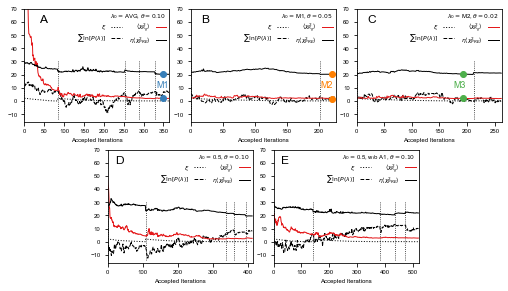

In [18]:
fig = plt.figure(figsize=(7,4))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

for ax,n,eta,d,l0 in zip([ax1,ax2,ax3,ax4,ax5],[10,5,2,10,10],[1,1,1,1,1],
                         ['10_AVG','5_M1','2_M2','10_5','10_5_noA1'],
                         ['AVG','M1','M2','0.5','0.5, w/o A1']):
    chi2_rg = np.empty(0)
    chi2_rh = np.empty(0)
    chi2_pre = np.empty(0)
    chi2_kT = np.empty(0)
    prior = np.empty(0)
    i_max = 0
    acciter = 0
    for i in range(1,10):
        if os.path.isfile('optimization/{:s}/o{:d}_chi2.pkl'.format(d,i)):
            df = pd.read_pickle('optimization/{:s}/o{:d}_chi2.pkl'.format(d,i))
            ax.vlines(df.index[0]+acciter,-14,30,linestyle=':',color='k',lw=.8)
            acciter += df.index.size
            if i>2:
                chi2_kT = np.append(chi2_kT,.1*(.99**df.index))
            elif i==2 and n<10:
                chi2_kT = np.append(chi2_kT,.1*(.99**df.index))
            else:
                chi2_kT = np.append(chi2_kT,2*(.99**df.index))
            chi2_rg = np.append(chi2_rg,df.chi2_rg.values.astype(float))
            chi2_pre = np.append(chi2_pre,df.chi2_pre.values.astype(float)/eta)
            prior = np.append(prior,df.prior.values.astype(float))
            
    ax.plot(chi2_kT,label=r'$\xi$',ls=':',color='k',lw=1)        
    ax.plot(prior,label=r'$\sum \ln{[P(\lambda)]}$',ls='--',color='k',lw=1)
    ax.plot(chi2_rg,label=r'$\langle \chi^2_{R_g} \rangle$',color=cm[4],lw=1)
    ax.plot(chi2_pre,label=r'$\eta \langle  \chi^2_{PRE} \rangle$',color='k',lw=1)
    
    if l0=='AVG' and opt_results.loc['chi2_rg','M1'] in chi2_rg:
        x = np.where(chi2_rg==opt_results.loc['chi2_rg','M1'])[0]
        ax.plot(x,opt_results.loc['chi2_rg','M1'],marker='o',color=cm[0])
        ax.plot(x,opt_results.loc['chi2_pre','M1'],marker='o',color=cm[0])
        y = .5*(opt_results.loc['chi2_rg','M1']+opt_results.loc['chi2_pre','M1'])
        ax.annotate('M1', (x-17, y-1), color=cm[0], fontsize=9, xycoords='data')
    if l0=='M1' and opt_results.loc['chi2_rg','M2'] in chi2_rg:
        x = np.where(chi2_rg==opt_results.loc['chi2_rg','M2'])[0]
        ax.plot(x,opt_results.loc['chi2_rg','M2'],marker='o',color=cm[1])
        ax.plot(x,opt_results.loc['chi2_pre','M2'],marker='o',color=cm[1])
        y = .5*(opt_results.loc['chi2_rg','M2']+opt_results.loc['chi2_pre','M2'])
        ax.annotate('M2', (x-17, y-1), color=cm[1], fontsize=9, xycoords='data')
    if l0=='M2' and opt_results.loc['chi2_rg','M3'] in chi2_rg:
        x = np.where(chi2_rg==opt_results.loc['chi2_rg','M3'])[0]
        ax.plot(x,opt_results.loc['chi2_rg','M3'],marker='o',color=cm[2])
        ax.plot(x,opt_results.loc['chi2_pre','M3'],marker='o',color=cm[2])
        y = .5*(opt_results.loc['chi2_rg','M3']+opt_results.loc['chi2_pre','M3'])
        ax.annotate('M3', (x-17, y-1), color=cm[2], fontsize=9, xycoords='data')

    ax.set_ylim(-16,70)
    ax.set_xlim(0,chi2_kT.size)
    leg = ax.legend(title=r'$\lambda_0=${:s}, $\theta={:.2f}$'.format(l0,n/100),frameon=False,ncol=2,
          borderpad=0,columnspacing=1.2,labelspacing=.1,
          handlelength=1.8,markerfirst=False)
    leg._legend_box.align = "right"
    
    ax.set_xlabel('Accepted Iterations')

fig.text(0.07, .93, 'A', fontsize=12)
fig.text(0.39, .93, 'B', fontsize=12)
fig.text(0.72, .93, 'C', fontsize=12)
fig.text(0.22, .44, 'D', fontsize=12)
fig.text(0.55, .44, 'E', fontsize=12)

plt.tight_layout()
plt.savefig('figures/chi2.pdf')

<a id='S2'></a>

### Fig. S2

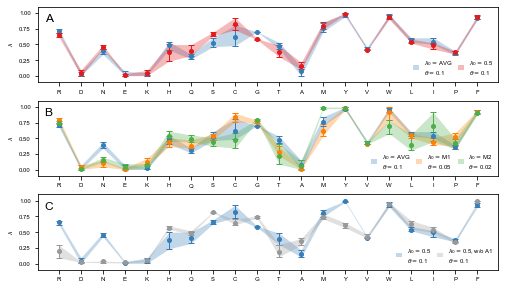

In [19]:
fig = plt.figure(figsize=(7,4))
ax1 = plt.subplot2grid( (3,1), (0,0), rowspan=1, colspan=1 )
ax2 = plt.subplot2grid( (3,1), (1,0), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (3,1), (2,0), rowspan=1, colspan=1 )

r = pd.read_csv('residues.csv').set_index('three')
df1_0 = pd.read_pickle('optimization/10_5/o4_lambdas.pkl')
df1_1 = pd.read_pickle('optimization/10_5/o5_lambdas.pkl')
df1_5 = pd.concat((df1_0,df1_1)).reset_index().drop('index',axis=1)
df1 = pd.read_pickle('optimization/10_AVG/o5_lambdas.pkl').reset_index().drop('index',axis=1)
df2_0 = pd.read_pickle('optimization/5_M1/o1_lambdas.pkl')
df2_1 = pd.read_pickle('optimization/5_M1/o2_lambdas.pkl')
df2 = pd.concat((df2_0,df2_1)).reset_index().drop('index',axis=1)
df3 = pd.read_pickle('optimization/2_M2/o1_lambdas.pkl')
dfnoA1 = pd.read_pickle('optimization/10_5_noA1/o3_lambdas.pkl')

X1 = pd.DataFrame(dict((i,df1.loc[i].lambdas[:-2].values) for i in df1.index)).T
X2 = pd.DataFrame(dict((i,df2.loc[i].lambdas[:-2].values) for i in df2.index)).T
X3 = pd.DataFrame(dict((i,df3.loc[i].lambdas[:-2].values) for i in df3.index)).T
X4 = pd.DataFrame(dict((i,df1_5.loc[i].lambdas[:-2].values) for i in df1_5.index)).T
X5 = pd.DataFrame(dict((i,dfnoA1.loc[i].lambdas[:-2].values) for i in dfnoA1.index)).T

for X,c,l,t in zip([X1,X4],[0,4],['AVG','0.5'],[0.1,0.1]):
    yerr = np.append(X.mean(axis=0)-X.quantile(0.1,axis=0),
                     X.quantile(0.9,axis=0)-X.mean(axis=0)).reshape(2,-1)
    ax1.fill_between(r.one,y1=X.quantile(0.1,axis=0),
            y2=X.quantile(0.9,axis=0),alpha=.3,lw=0,color=cm[c],
                      label='$\lambda_0=${:s}\n'.format(l)+r'$\theta=${:g}'.format(t))
    ax1.errorbar(r.one,X.mean(axis=0),yerr,lw=0,color=cm[c],
        marker='o', ms=4, elinewidth=1, capsize=3, capthick=1)
    
for X,c,l,t in zip([X1,X2,X3],[0,1,2],['AVG','M1','M2'],[0.1,0.05,0.02]):
    yerr = np.append(X.mean(axis=0)-X.quantile(0.1,axis=0),
                     X.quantile(0.9,axis=0)-X.mean(axis=0)).reshape(2,-1)
    ax2.fill_between(r.one,y1=X.quantile(0.1,axis=0),
            y2=X.quantile(0.9,axis=0),alpha=.3,lw=0,color=cm[c],
                      label='$\lambda_0=${:s}\n'.format(l)+r'$\theta=${:g}'.format(t))
    ax2.errorbar(r.one,X.mean(axis=0),yerr,lw=0,color=cm[c],
        marker='o', ms=4, elinewidth=1, capsize=3, capthick=1)
    
for X,c,l,t in zip([X4,X5],[0,3],['0.5','0.5, w/o A1'],[0.1,0.1]):
    yerr = np.append(X.mean(axis=0)-X.quantile(0.1,axis=0),
                     X.quantile(0.9,axis=0)-X.mean(axis=0)).reshape(2,-1)
    ax3.fill_between(r.one,y1=X.quantile(0.1,axis=0),
            y2=X.quantile(0.9,axis=0),alpha=.3,lw=0,color=cm[c],
                      label='$\lambda_0=${:s}\n'.format(l)+r'$\theta=${:g}'.format(t))
    ax3.errorbar(r.one,X.mean(axis=0),yerr,lw=0,color=cm[c],
        marker='o', ms=4, elinewidth=1, capsize=3, capthick=1) 
 
for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('$\lambda$')
    ax.set_ylim(-.1,1.1)
    ax.legend(frameon=False,ncol=3,loc='lower right',handlelength=1,columnspacing=1)

ax1.annotate('A', fontsize=12, xy=(-.65,.86))
ax2.annotate('B', fontsize=12, xy=(-.65,.86))
ax3.annotate('C', fontsize=12, xy=(-.65,.86))

plt.tight_layout()
plt.savefig('figures/lambda_range.pdf')

<a id='S13'></a>

### Fig. S13

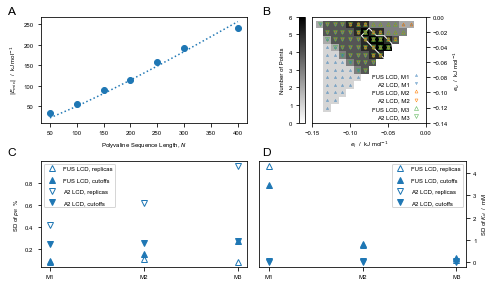

In [20]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7,4))

polyV_length = [50,100,150,200,250,300,400]
frame_energies = {}
for N in polyV_length:
    ha = np.load('two-chain/data/polyV/{:s}_energies.npy'.format('V'+str(N)))
    frame_energies[N] = ha
frame_energies = pd.Series(frame_energies)
min_energy = frame_energies.apply(lambda x : abs(x.min()))

B22KdpB_A2 = pd.read_pickle('two-chain/data/dfB22KdpB_A2.pkl')
B22KdpB_FUS = pd.read_pickle('two-chain/data/dfB22KdpB_FUS.pkl')
B22KdpB_dual_A2 = pd.read_pickle('two-chain/data/dfB22KdpB_dual_A2.pkl')
B22KdpB_dual_FUS = pd.read_pickle('two-chain/data/dfB22KdpB_dual_FUS.pkl')

cutoffs = pd.read_pickle('two-chain/data/cutoffs.pkl')
NlogN = lambda x,a: a*x*np.log(np.array(x))

all_x = np.empty(0)
all_y = np.empty(0)
for name in cutoffs.index:
    x1 = cutoffs.loc[name,'FUS'][0]
    y1 = cutoffs.loc[name,'FUS'][1]
    x2 = cutoffs.loc[name,'A2'][0]
    y2 = cutoffs.loc[name,'A2'][1]
    all_x = np.append(all_x,np.concatenate([x1,x2]))
    all_y = np.append(all_y,np.concatenate([y1,y2]))

min_energy.plot(ax=ax1,lw=0,color='tab:blue',marker='o')
ax1.set_xlabel('Polyvaline Sequence Length, $N$')
ax1.set_ylabel('$|E_{min}|$  /  kJ mol$^{-1}$')
NlogN_fit,_ = curve_fit(NlogN,min_energy.index,min_energy.values)
ax1.plot(min_energy.index,NlogN(min_energy.index,*NlogN_fit),color='tab:blue',linestyle='dotted')

for (model,data),c,ms in zip(cutoffs.iterrows(),cm[:3],[2,3,4]):
    ax2.plot(data.FUS[0],data.FUS[1],marker='^',color=c,mfc='None',lw=0,label='FUS LCD, '+model,
             ms=ms,markeredgewidth=.5)
    ax2.plot(data.A2[0],data.A2[1],marker='v',color=c,mfc='None',lw=0,label='A2 LCD, '+model,
             ms=ms,markeredgewidth=.5)
ax2.legend(frameon=False,markerfirst=False,handletextpad=.05,borderpad=.1)
ax2.set_ylabel('$e_u$  /  kJ mol$^{-1}$')
ax2.set_xlabel('$e_l$  /  kJ mol$^{-1}$')
bins = np.arange(-.15,0.01,0.01)
h, xbins, ybins = np.histogram2d(all_x,all_y,bins=bins,density=False)
im = ax2.imshow(h.T,extent=[xbins.min()-.005,xbins.max()-.005,ybins.min()+.005,ybins.max()+.005],origin='lower',
           cmap=plt.cm.binary)
ax2.contour(xbins[:-1]+.005,ybins[:-1]+.005,h.T,[5],origin='lower',colors=['w'],linewidths=[1])
ax2.set_xlim(-.15,0)
ax2.set_ylim(-.14,0)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("left", size='5%',pad=.1) 
fig.add_axes(cax2)
plt.colorbar(im, cax=cax2, orientation="vertical", label=r'Number of Points')
cax2.yaxis.set_ticks_position('left')
cax2.yaxis.set_label_position('left')

B22KdpB_FUS.pB_E.plot(ax=ax3,marker='^',lw=0,mfc='None',color='tab:blue',label='FUS LCD, replicas')
B22KdpB_dual_FUS.pB_E.plot(ax=ax3,marker='^',lw=0,color='tab:blue',label='FUS LCD, cutoffs')
B22KdpB_A2.pB_E.plot(ax=ax3,marker='v',lw=0,mfc='None',color='tab:blue',label='A2 LCD, replicas')
B22KdpB_dual_A2.pB_E.plot(ax=ax3,marker='v',lw=0,color='tab:blue',label='A2 LCD, cutoffs')

ax3.legend(frameon=True,markerfirst=True,labelspacing=1)
ax3.set_ylabel('SD of $p_B$  %')

B22KdpB_FUS.Kd_E.plot(ax=ax4,marker='^',lw=0,mfc='None',color='tab:blue',label='FUS LCD, replicas')
B22KdpB_dual_FUS.Kd_E.plot(ax=ax4,marker='^',lw=0,color='tab:blue',label='FUS LCD, cutoffs')
B22KdpB_A2.Kd_E.plot(ax=ax4,marker='v',lw=0,mfc='None',color='tab:blue',label='A2 LCD, replicas')
B22KdpB_dual_A2.Kd_E.plot(ax=ax4,marker='v',lw=0,color='tab:blue',label='A2 LCD, cutoffs')

ax2.set_xticks(np.arange(-.15,0.01,.05))
ax3.set_xticks(range(3))
ax4.set_xticks(range(3))

ax4.legend(frameon=True,markerfirst=True,labelspacing=1)
ax4.set_ylabel('SD of $K_d$  /  mM')

ax2.yaxis.set_ticks_position('right'); ax2.yaxis.set_label_position('right')
ax4.yaxis.set_ticks_position('right'); ax4.yaxis.set_label_position('right')

fig.text(0.02, .96, 'A', fontsize=12)
fig.text(0.525, .96, 'B', fontsize=12)
fig.text(0.02, .47, 'C', fontsize=12)
fig.text(0.525, .47, 'D', fontsize=12)

plt.tight_layout(pad=2)
plt.savefig('figures/Kd.pdf')

<a id='S17'></a>

### Fig. S17

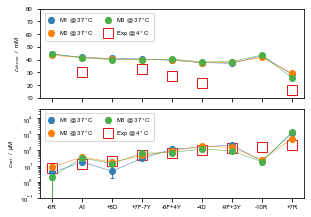

In [21]:
cm = ['#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

fig, (ax1,ax2) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(4.3,3))


rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value_310.pkl')
rho_dense_e = pd.read_pickle('multi-chain/data/rho_dense_error_310.pkl')

variants = ['M6R','A1','P8D','P7FM7Y', 'M8FP4Y', 'M4D', 'M9FP3Y','M10R', 'P7R'] 
names = [a.replace('M','-').replace('P','+') for a in variants]
rho_dense_v.loc[variants,'Exp'] = [7.7,13.3,20.4,52.2,68.6,96.6,131.5,150.8,198.3]
ms = ['M1_den','M2_den','M3_den']
rho_dense_v.loc[variants,ms].plot(ax=ax1,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)

ms = ['M1_dil','M2_dil','M3_dil']
rho_dense_v.loc[variants,ms].plot(ax=ax2,yerr=rho_dense_e.loc[variants,ms],lw=0.5,
                                  marker='o',elinewidth=1, capsize=2, capthick=1)

ax1.plot(variants,[-10, 30, -10, 33, 27, 22, -10, -10, 16],
         color=cm[3],lw=0,marker='s',ms=10,mfc='none',label='Exp @ 4$^\circ$C')
ax2.plot(variants,rho_dense_v.loc[variants,'Exp'],color=cm[3],lw=0,marker='s',ms=10,mfc='none',
        label='Exp @ 4$^\circ$C')
ax2.set_yscale('log')



ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([])
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names,rotation=0)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[1:]+handles[:1],['M1 @ 37$^\circ$C','M2 @ 37$^\circ$C','M3 @ 37$^\circ$C',
                                    'Exp @ 4$^\circ$C'],frameon=True,ncol=2,loc=(.02,.64),
          handlelength=1,columnspacing=2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[1:]+handles[:1],['M1 @ 37$^\circ$C','M2 @ 37$^\circ$C','M3 @ 37$^\circ$C',
                                    'Exp @ 4$^\circ$C'],frameon=True,ncol=2,loc=(.02,.64),
          handlelength=1,columnspacing=2)
    
ax1.set_ylim(10,80)
ax2.set_ylim(.1,4e4)

ax1.set_ylabel('$c_{dense}$  /  mM')
ax2.set_ylabel('$c_{sat}$  /  µM')

fig.tight_layout()
plt.savefig('figures/M123_conc_310.pdf')

<a id='S18'></a>

### Fig. S18

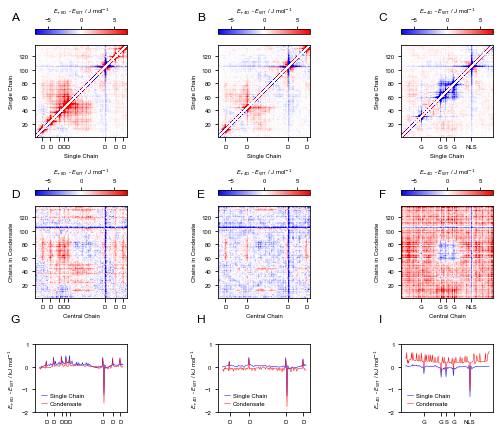

In [22]:
f = plt.figure(figsize=(7,6))
ax1 = plt.subplot2grid( (8,8), (0,0), rowspan=3, colspan=2 )
ax2 = plt.subplot2grid( (8,8), (0,3), rowspan=3, colspan=2 )
ax3 = plt.subplot2grid( (8,8), (0,6), rowspan=3, colspan=2 )
ax4 = plt.subplot2grid( (8,8), (3,0), rowspan=3, colspan=2 )
ax5 = plt.subplot2grid( (8,8), (3,3), rowspan=3, colspan=2 )
ax6 = plt.subplot2grid( (8,8), (3,6), rowspan=3, colspan=2 )
ax7 = plt.subplot2grid( (8,8), (6,0), rowspan=2, colspan=2 )
ax8 = plt.subplot2grid( (8,8), (6,3), rowspan=2, colspan=2 )
ax9 = plt.subplot2grid( (8,8), (6,6), rowspan=2, colspan=2 )
plt.rcParams.update({ 'font.size': 6 })

up = ax1,ax2,ax3
middle = ax4,ax5,ax6
down = ax7,ax8,ax9
        
plotMap(up[0],P8D_1-A1_1,r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,ori='horizontal')
plotMap(up[1],P4D_1-A1_1,r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,ori='horizontal')
plotMap(up[2],M4D_1-A1_1,r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,ori='horizontal')

plotMap(middle[0],P8D_multi-A1_multi,r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')
plotMap(middle[1],P4D_multi-A1_multi,r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')
plotMap(middle[2],M4D_multi-A1_multi,r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT}}$ / J mol$^{-1}$',-7,7,xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')

ticks = np.arange(.5,len(proteins.loc['P8D'].fasta),1)
boolP8D = [j=='D' and i!='D' for i,j in zip(proteins.loc['A1'].fasta,proteins.loc['P8D'].fasta)]
xticks = ticks[boolP8D]
xlabels = np.array(proteins.loc['P8D'].fasta)[boolP8D]
for ax in (up[0],middle[0],down[0]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

ticks = np.arange(.5,len(proteins.loc['P4D'].fasta),1)
boolP4D = [j=='D' and i!='D' for i,j in zip(proteins.loc['A1'].fasta,proteins.loc['P4D'].fasta)]
xticks = ticks[boolP4D]
xlabels = np.array(proteins.loc['P4D'].fasta)[boolP4D]
for ax in (up[1],middle[1],down[1]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

ticks = np.arange(.5,len(proteins.loc['M4D'].fasta),1)
boolM4D = [i=='D' for i in proteins.loc['A1'].fasta]
boolM4D[104] = True
xticks = ticks[boolM4D]
xlabels = np.array(proteins.loc['M4D'].fasta)[boolM4D]
xlabels = np.append( xlabels[:-1], 'NLS')
for ax in (up[2],middle[2],down[2]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    
A1_s1 = np.nansum(np.where(np.triu(np.ones(A1_1.shape),k=3).astype(bool),A1_1.values,np.nan),axis=0)
A1_s2 = np.nansum(np.where(np.tril(np.ones(A1_1.shape),k=-3).astype(bool),A1_1.values,np.nan),axis=0)
A1_s = (A1_s1 + A1_s2)

P8D_s1 = np.nansum(np.where(np.triu(np.ones(P8D_1.shape),k=3).astype(bool),P8D_1.values,np.nan),axis=0)
P8D_s2 = np.nansum(np.where(np.tril(np.ones(P8D_1.shape),k=-3).astype(bool),P8D_1.values,np.nan),axis=0)
P8D_s = (P8D_s1 + P8D_s2)

P4D_s1 = np.nansum(np.where(np.triu(np.ones(P4D_1.shape),k=3).astype(bool),P4D_1.values,np.nan),axis=0)
P4D_s2 = np.nansum(np.where(np.tril(np.ones(P4D_1.shape),k=-3).astype(bool),P4D_1.values,np.nan),axis=0)
P4D_s = (P4D_s1 + P4D_s2)

M4D_s1 = np.nansum(np.where(np.triu(np.ones(M4D_1.shape),k=3).astype(bool),M4D_1.values,np.nan),axis=0)
M4D_s2 = np.nansum(np.where(np.tril(np.ones(M4D_1.shape),k=-3).astype(bool),M4D_1.values,np.nan),axis=0)
M4D_s = (M4D_s1 + M4D_s2)

down[0].plot(P8D_s-A1_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[0].plot((P8D_multi-A1_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

down[1].plot(P4D_s-A1_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[1].plot((P4D_multi-A1_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

down[2].plot(M4D_s-A1_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[2].plot((M4D_multi-A1_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

ylabels = [r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$',
          r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$',
          r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$']
for ax,ylabel in zip(down,ylabels):
    leg = ax.legend(frameon=False,handlelength=1,handletextpad=.5)
    leg._legend_box.align = "left"
    ax.set_ylabel(ylabel)
    ax.set_ylim(-2,1)
    
f.text(0.03, .95, 'A', fontsize=12)
f.text(0.4, .95, 'B', fontsize=12)
f.text(0.76, .95, 'C', fontsize=12)
f.text(0.03, .54, 'D', fontsize=12)
f.text(0.4, .54, 'E', fontsize=12)
f.text(0.76, .54, 'F', fontsize=12)
f.text(0.03, .25, 'G', fontsize=12)
f.text(0.4, .25, 'H', fontsize=12)
f.text(0.76, .25, 'I', fontsize=12)
f.tight_layout(w_pad=-.5)    
f.savefig('figures/mapsDvariants.png',dpi=300)
plt.show()

<a id='S19'></a>

### Fig. S19

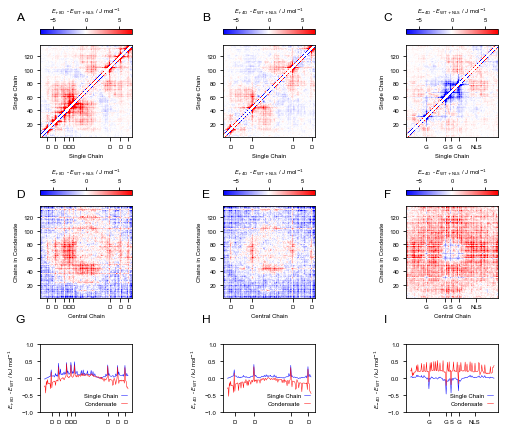

In [23]:
f = plt.figure(figsize=(7,6))
ax1 = plt.subplot2grid( (8,8), (0,0), rowspan=3, colspan=2 )
ax2 = plt.subplot2grid( (8,8), (0,3), rowspan=3, colspan=2 )
ax3 = plt.subplot2grid( (8,8), (0,6), rowspan=3, colspan=2 )
ax4 = plt.subplot2grid( (8,8), (3,0), rowspan=3, colspan=2 )
ax5 = plt.subplot2grid( (8,8), (3,3), rowspan=3, colspan=2 )
ax6 = plt.subplot2grid( (8,8), (3,6), rowspan=3, colspan=2 )
ax7 = plt.subplot2grid( (8,8), (6,0), rowspan=2, colspan=2 )
ax8 = plt.subplot2grid( (8,8), (6,3), rowspan=2, colspan=2 )
ax9 = plt.subplot2grid( (8,8), (6,6), rowspan=2, colspan=2 )
plt.rcParams.update({ 'font.size': 6 })

up = ax1,ax2,ax3
middle = ax4,ax5,ax6
down = ax7,ax8,ax9
        
plotMap(up[0],P8D_1-A1NLS_1,r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,ori='horizontal')
plotMap(up[1],P4D_1-A1NLS_1,r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,ori='horizontal')
plotMap(up[2],M4D_1-A1NLS_1,r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,ori='horizontal')

plotMap(middle[0],P8D_multi-A1NLS_multi,r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,
        xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')
plotMap(middle[1],P4D_multi-A1NLS_multi,r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,
        xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')
plotMap(middle[2],M4D_multi-A1NLS_multi,r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT+NLS}}$ / J mol$^{-1}$',-7,7,
        xlabel='Central Chain',
        ylabel='Chains in Condensate',ori='horizontal')

ticks = np.arange(.5,len(proteins.loc['P8D'].fasta),1)
boolP8D = [j=='D' and i!='D' for i,j in zip(proteins.loc['A1'].fasta,proteins.loc['P8D'].fasta)]
xticks = ticks[boolP8D]
xlabels = np.array(proteins.loc['P8D'].fasta)[boolP8D]
for ax in (up[0],middle[0],down[0]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

ticks = np.arange(.5,len(proteins.loc['P4D'].fasta),1)
boolP4D = [j=='D' and i!='D' for i,j in zip(proteins.loc['A1'].fasta,proteins.loc['P4D'].fasta)]
xticks = ticks[boolP4D]
xlabels = np.array(proteins.loc['P4D'].fasta)[boolP4D]
for ax in (up[1],middle[1],down[1]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

ticks = np.arange(.5,len(proteins.loc['M4D'].fasta),1)
boolM4D = [i=='D' for i in proteins.loc['A1'].fasta]
boolM4D[104] = True
xticks = ticks[boolM4D]
xlabels = np.array(proteins.loc['M4D'].fasta)[boolM4D]
xlabels = np.append( xlabels[:-1], 'NLS')
for ax in (up[2],middle[2],down[2]):
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    
A1NLS_s1 = np.nansum(np.where(np.triu(np.ones(A1NLS_1.shape),k=3).astype(bool),A1NLS_1.values,np.nan),axis=0)
A1NLS_s2 = np.nansum(np.where(np.tril(np.ones(A1NLS_1.shape),k=-3).astype(bool),A1NLS_1.values,np.nan),axis=0)
A1NLS_s = (A1NLS_s1 + A1NLS_s2)

P8D_s1 = np.nansum(np.where(np.triu(np.ones(P8D_1.shape),k=3).astype(bool),P8D_1.values,np.nan),axis=0)
P8D_s2 = np.nansum(np.where(np.tril(np.ones(P8D_1.shape),k=-3).astype(bool),P8D_1.values,np.nan),axis=0)
P8D_s = (P8D_s1 + P8D_s2)

P4D_s1 = np.nansum(np.where(np.triu(np.ones(P4D_1.shape),k=3).astype(bool),P4D_1.values,np.nan),axis=0)
P4D_s2 = np.nansum(np.where(np.tril(np.ones(P4D_1.shape),k=-3).astype(bool),P4D_1.values,np.nan),axis=0)
P4D_s = (P4D_s1 + P4D_s2)

M4D_s1 = np.nansum(np.where(np.triu(np.ones(M4D_1.shape),k=3).astype(bool),M4D_1.values,np.nan),axis=0)
M4D_s2 = np.nansum(np.where(np.tril(np.ones(M4D_1.shape),k=-3).astype(bool),M4D_1.values,np.nan),axis=0)
M4D_s = (M4D_s1 + M4D_s2)

down[0].plot(P8D_s-A1NLS_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[0].plot((P8D_multi-A1NLS_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

down[1].plot(P4D_s-A1NLS_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[1].plot((P4D_multi-A1NLS_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

down[2].plot(M4D_s-A1NLS_s,color=plt.cm.bwr(0.01),label='Single Chain',lw=0.5)
down[2].plot((M4D_multi-A1NLS_multi).sum(axis=0),color=plt.cm.bwr(0.99),label='Condensate',lw=0.5)

ylabels = [r'$E_{\mathrm{+8D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$',
          r'$E_{\mathrm{+4D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$',
          r'$E_{\mathrm{-4D}}$ - $E_{\mathrm{WT}}$ / kJ mol$^{-1}$']
for ax,ylabel in zip(down,ylabels):
    leg = ax.legend(frameon=False,handlelength=1,handletextpad=.5,loc='lower right',markerfirst=False)
    leg._legend_box.align = "left"
    ax.set_ylabel(ylabel)
    ax.set_ylim(-1,1)
    
f.text(0.03, .95, 'A', fontsize=12)
f.text(0.4, .95, 'B', fontsize=12)
f.text(0.76, .95, 'C', fontsize=12)
f.text(0.03, .54, 'D', fontsize=12)
f.text(0.4, .54, 'E', fontsize=12)
f.text(0.76, .54, 'F', fontsize=12)
f.text(0.03, .25, 'G', fontsize=12)
f.text(0.4, .25, 'H', fontsize=12)
f.text(0.76, .25, 'I', fontsize=12)
f.tight_layout(w_pad=-.5)    
f.savefig('figures/mapsDvariantsPYNLS.png',dpi=300)
plt.show()

<a id='S14'></a>

### Fig. S14

62.851980015927246
40.654449066542576
63.56794484026264
48.90045294044535


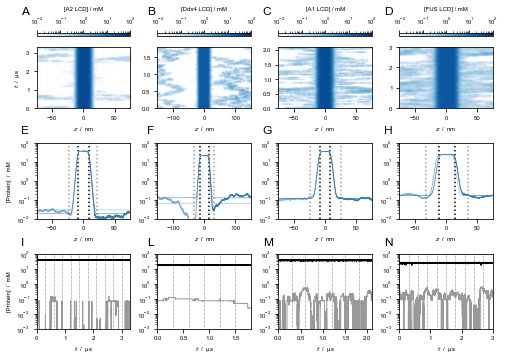

In [24]:
f, (up,middle,down) = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(7,5))
cm = ['#999999', '#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']
model = 'M1'

h1 = plotCvsTime(up[0],'A2',model,'[A2 LCD] / mM')
h2 = plotCvsTime(up[1],'Ddx4WT',model,'[Ddx4 LCD] / mM')
h3 = plotCvsTime(up[2],'A1',model,'[A1 LCD] / mM')
h4 = plotCvsTime(up[3],'FUS',model,'[FUS LCD] / mM')

plotCprofile(middle[0],h1)
plotCprofile(middle[1],h2)
plotCprofile(middle[2],h3)
plotCprofile(middle[3],h4)

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value.pkl')
for name,ax,h in zip(['A2','Ddx4WT','A1','FUS'],down,[h1,h2,h3,h4]):
    t = np.arange(h.shape[0])*250/1e6
    ax.plot(t,rho_dense_v.loc[name,'{:s}_dilarray'.format(model)]/1e3,color=cm[0],lw=1)
    ax.plot(t,rho_dense_v.loc[name,'{:s}_denarray'.format(model)],color='k',lw=1)
    ax.set_yscale('log')
    ax.set_xlim(0,t.max())
    ax.set_ylim(1e-3,1e2)
    ax.set_xlabel('$t$  /  µs')
    ax.vlines(np.arange(t.max()%0.3,t.max(),0.3),1e-3,1e2,ls=':',lw=.5,color='k')

up[0].set_ylabel('$t$  /  µs') 
middle[0].set_ylabel('[Protein]  /  mM')
down[0].set_ylabel('[Protein]  /  mM')

f.text(0.04, .96, 'A', fontsize=12)
f.text(0.29, .96, 'B', fontsize=12)
f.text(0.52, .96, 'C', fontsize=12)
f.text(0.76, .96, 'D', fontsize=12)
f.text(0.04, .63, 'E', fontsize=12)
f.text(0.29, .63, 'F', fontsize=12)
f.text(0.52, .63, 'G', fontsize=12)
f.text(0.76, .63, 'H', fontsize=12)
f.text(0.04, .32, 'I', fontsize=12)
f.text(0.29, .32, 'L', fontsize=12)
f.text(0.52, .32, 'M', fontsize=12)
f.text(0.76, .32, 'N', fontsize=12)

f.tight_layout()    
f.savefig('figures/ProfilesVsTime.png',dpi=300)
plt.show()

<a id='S15'></a>

### Fig. S15

63.02923344331127
64.10665623721401
63.56794484026264
57.64211947379748
7200
10800
8400
7200


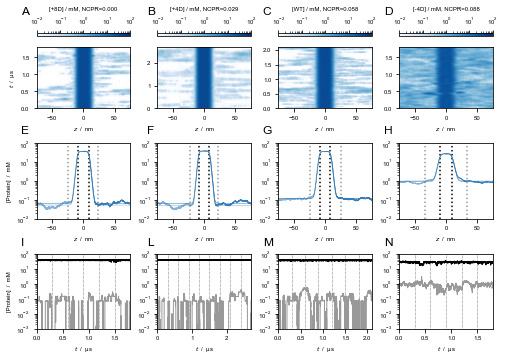

In [25]:
f, (up,middle,down) = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(7,5))
cm = ['#999999', '#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']

model = 'M1'

h1 = plotCvsTime(up[0],'P8D',model,'[+8D] / mM, NCPR={:.3f}'.format(df_nu.loc['P8D','NCPR']))
h2 = plotCvsTime(up[1],'P4D',model,'[+4D] / mM, NCPR={:.3f}'.format(df_nu.loc['P4D','NCPR']))
h3 = plotCvsTime(up[2],'A1',model,'[WT] / mM, NCPR={:.3f}'.format(df_nu.loc['A1','NCPR']))
h4 = plotCvsTime(up[3],'M4D',model,'[-4D] / mM, NCPR={:.3f}'.format(df_nu.loc['M4D','NCPR']))

plotCprofile(middle[0],h1)
plotCprofile(middle[1],h2)
plotCprofile(middle[2],h3)
plotCprofile(middle[3],h4)

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value.pkl')
for name,ax,h in zip(['P8D','P4D','A1','M4D'],down,[h1,h2,h3,h4]):
    t = np.arange(h.shape[0])*250/1e6
    print(t.size)
    ax.plot(t,rho_dense_v.loc[name,'{:s}_dilarray'.format(model)]/1e3,color=cm[0],lw=1)
    ax.plot(t,rho_dense_v.loc[name,'{:s}_denarray'.format(model)],color='k',lw=1)
    ax.set_yscale('log')
    ax.set_xlim(0,t.max())
    ax.set_ylim(1e-3,1e2)
    ax.set_xlabel('$t$  /  µs')
    ax.vlines(np.arange(t.max()%0.3,t.max(),0.3),1e-3,1e2,ls=':',lw=.5,color='k')

up[0].set_ylabel('$t$  /  µs') 
middle[0].set_ylabel('[Protein]  /  mM')
down[0].set_ylabel('[Protein]  /  mM')

f.text(0.04, .96, 'A', fontsize=12)
f.text(0.29, .96, 'B', fontsize=12)
f.text(0.52, .96, 'C', fontsize=12)
f.text(0.76, .96, 'D', fontsize=12)
f.text(0.04, .63, 'E', fontsize=12)
f.text(0.29, .63, 'F', fontsize=12)
f.text(0.52, .63, 'G', fontsize=12)
f.text(0.76, .63, 'H', fontsize=12)
f.text(0.04, .32, 'I', fontsize=12)
f.text(0.29, .32, 'L', fontsize=12)
f.text(0.52, .32, 'M', fontsize=12)
f.text(0.76, .32, 'N', fontsize=12)

f.tight_layout()    
f.savefig('figures/ProfilesVsTimeA1variants.png',dpi=300)
plt.show()

<a id='S16'></a>

### Fig. S16

62.851980015927246
63.8042827434413
61.89967728841321
66.18503956222644


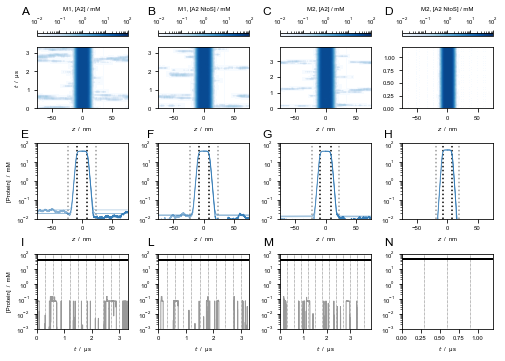

In [26]:
f, (up,middle,down) = plt.subplots(3, 4, sharex=False, sharey=False, figsize=(7,5))
cm = ['#999999', '#377eb8', '#ff7f00', '#4daf4a',  '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00', '#000000']

h1 = plotCvsTime(up[0],'A2','M1','M1, [A2] / mM')
h2 = plotCvsTime(up[1],'A2NS','M1','M1, [A2 NtoS] / mM')
h3 = plotCvsTime(up[2],'A2','M2','M2, [A2] / mM')
h4 = plotCvsTime(up[3],'A2NS','M2','M2, [A2 NtoS] / mM')

plotCprofile(middle[0],h1)
plotCprofile(middle[1],h2)
plotCprofile(middle[2],h3)
plotCprofile(middle[3],h4)

rho_dense_v = pd.read_pickle('multi-chain/data/rho_dense_value.pkl')
for name,model,ax,h in zip(['A2','A2NS','A2','A2NS'],['M1','M1','M2','M2'],down,[h1,h2,h3,h4]):
    t = np.arange(h.shape[0])*250/1e6
    ax.plot(t,rho_dense_v.loc[name,'{:s}_dilarray'.format(model)]/1e3,color=cm[0],lw=1)
    ax.plot(t,rho_dense_v.loc[name,'{:s}_denarray'.format(model)],color='k',lw=1)
    ax.set_yscale('log')
    ax.set_xlim(0,t.max())
    ax.set_ylim(1e-3,1e2)
    ax.set_xlabel('$t$  /  µs')
    ax.vlines(np.arange(t.max()%0.3,t.max(),0.3),1e-3,1e2,ls=':',lw=.5,color='k')

up[0].set_ylabel('$t$  /  µs') 
middle[0].set_ylabel('[Protein]  /  mM')
down[0].set_ylabel('[Protein]  /  mM')

f.text(0.04, .96, 'A', fontsize=12)
f.text(0.29, .96, 'B', fontsize=12)
f.text(0.52, .96, 'C', fontsize=12)
f.text(0.76, .96, 'D', fontsize=12)
f.text(0.04, .62, 'E', fontsize=12)
f.text(0.29, .62, 'F', fontsize=12)
f.text(0.52, .62, 'G', fontsize=12)
f.text(0.76, .62, 'H', fontsize=12)
f.text(0.04, .32, 'I', fontsize=12)
f.text(0.29, .32, 'L', fontsize=12)
f.text(0.52, .32, 'M', fontsize=12)
f.text(0.76, .32, 'N', fontsize=12)

f.tight_layout()    
f.savefig('figures/ProfilesVsTimeNS.png',dpi=300)
plt.show()